# Starting point

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Define file paths
inputpath = Path(r'.\Inputs')
additionalpath = Path(r'.\Inputs\Additional')

# Load data from CSV files
windgen  = pd.read_csv(inputpath / 'Capacity of wind farms.csv', sep=';')
demand  = pd.read_csv(inputpath / 'Loads.csv', sep=';')
wind_cf = pd.read_excel(additionalpath / 'windpower.xlsx')
load_dist = pd.read_csv(additionalpath / 'ProductionConsumptionSettlement.csv', sep=';')
weather = pd.read_csv(additionalpath / 'hourly_data.csv', sep=',')

windgen = windgen.values.T
demand = demand.values.T

# Wind generation capacity in MW
wind_cf['time'] = pd.to_datetime(wind_cf['time'], format='%Y-%m-%d %H:%M')
wind_cf = wind_cf[wind_cf['time'].dt.year == 2019]
# Extract data
wind_cf = wind_cf[['time', 'electricity','wind_speed']]

# Select hourly data from 2023 and DK2
load_dist = load_dist[load_dist['PriceArea'] == "DK2"]
load_dist['HourUTC'] = pd.to_datetime(load_dist['HourUTC'], format='%Y-%m-%d %H:%M')
load_dist = load_dist[load_dist['HourUTC'].dt.year == 2019]

# Extract load data
load_consumption = load_dist[['HourUTC', 'GrossConsumptionMWh']]
load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'].str.replace(',', '.').astype(float)

# Normalize data
max_load = load_consumption['GrossConsumptionMWh'].max()
load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'] / max_load


C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2499572321.py:9: DtypeWarning: Columns (5,16,21,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  load_dist = pd.read_csv(additionalpath / 'ProductionConsumptionSettlement.csv', sep=';')
C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2499572321.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_consumption['GrossConsumptionMWh'] = load_consumption['GrossConsumptionMWh'].str.replace(',', '.').astype(float)
C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2499572321.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

# Daily totals rescaling

In [3]:
# Initialize datafeatures with load_consumption
datafeatures = load_consumption.copy()

# Merge the combined samples with wind_cf on the 'HourUTC' and 'time' columns
datafeatures = datafeatures.merge(wind_cf[['time', 'electricity', 'wind_speed']], left_on='HourUTC', right_on='time', how='left')

# Drop the redundant 'time' column
datafeatures.drop(columns=['time'], inplace=True) 

datafeatures['ts'] = pd.to_datetime(datafeatures['HourUTC'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
datafeatures = datafeatures.sort_values(by='ts')

# Loads and wind farm profiles

In [4]:
# Rescale of total demand and wind production from real data
datafeatures['TotalDemand'] = (datafeatures['GrossConsumptionMWh']) * demand.sum()
datafeatures['TotalWind'] = datafeatures['electricity'] * windgen.sum()

# Fixed allocation along the different wind farms
for i in range(windgen.shape[1]):
    datafeatures[f'W{i+1}'] = windgen[0, i] * datafeatures['electricity']

# Random allocation along the different demand points
for i in range(demand.shape[1]):
    datafeatures[f'L{i+1}'] = datafeatures['GrossConsumptionMWh'] * demand[0, i]


# Verify that the total demand and wind production are preserved
assert np.allclose(datafeatures['L1'] + datafeatures['L2'] + datafeatures['L3'], datafeatures['TotalDemand'])
assert np.allclose(datafeatures['W1'] + datafeatures['W2'], datafeatures['TotalWind'])

In [5]:
mean_Demand = datafeatures['TotalDemand'].mean()
mean_TotalWind = datafeatures['TotalWind'].mean()

mean_L1 = datafeatures['L1'].mean()
mean_L2 = datafeatures['L2'].mean()
mean_L3 = datafeatures['L3'].mean()
mean_W1 = datafeatures['W1'].mean()
mean_W2 = datafeatures['W2'].mean()

print(f"Mean L1: {mean_L1}")
print(f"Mean L2: {mean_L2}")
print(f"Mean L3: {mean_L3}")
print(f"Mean W1: {mean_W1}")
print(f"Mean W2: {mean_W2}")
print(f"TotalDemand: {mean_Demand}")
print(f"TotalWind: {mean_TotalWind}")

max_L1 = datafeatures['L1'].max()
max_L2 = datafeatures['L2'].max()
max_L3 = datafeatures['L3'].max()
max_W1 = datafeatures['W1'].max()
max_W2 = datafeatures['W2'].max()

max_Demand = datafeatures['TotalDemand'].max()
max_TotalWind = datafeatures['TotalWind'].max()

print(f"Max L1: {max_L1}")
print(f"Max L2: {max_L2}")
print(f"Max L3: {max_L3}")
print(f"Max W1: {max_W1}")
print(f"Max W2: {max_W2}")
print(f"TotalDemand: {max_Demand}")
print(f"TotalWind: {max_TotalWind}")

Mean L1: 36.47470393239586
Mean L2: 72.94940786479172
Mean L3: 72.94940786479172
Mean W1: 15.520171232876711
Mean W2: 5.173390410958904
TotalDemand: 182.37351966197932
TotalWind: 20.693561643835615
Max L1: 56.0
Max L2: 112.0
Max L3: 112.0
Max W1: 29.73
Max W2: 9.91
TotalDemand: 280.0
TotalWind: 39.64


In [6]:
datafeatures = datafeatures.drop(columns=['GrossConsumptionMWh', 'electricity'])
datafeatures = datafeatures.drop(columns=['HourUTC'])
cols = ['ts'] + [col for col in datafeatures if col != 'ts']
datafeatures = datafeatures[cols]

# Seasonal Features

In [7]:
# extract the hour from the timestamp and add it as a new column
datafeatures['hour'] = datafeatures['ts'].dt.hour
datafeatures['day'] = datafeatures['ts'].dt.day
datafeatures['month'] = datafeatures['ts'].dt.month
datafeatures['hour_of_year'] = range(len(datafeatures))

# stationality variables
datafeatures[f'cos_hour_day'] = np.cos(2 * np.pi * datafeatures['hour'] / 24)
datafeatures[f'sin_hour_day'] = np.sin(2 * np.pi * datafeatures['hour'] / 24)
datafeatures[f'cos_day_month'] = np.cos(2 * np.pi * datafeatures['day'] / 30.4)
datafeatures[f'sin_day_month'] = np.sin(2 * np.pi * datafeatures['day'] / 30.4)
datafeatures[f'cos_month_year'] = np.cos(2 * np.pi * datafeatures['month'] / 12)
datafeatures[f'sin_month_year'] = np.sin(2 * np.pi * datafeatures['month'] / 12)
datafeatures[f'cos_hour_year'] = np.cos(2 * np.pi * datafeatures['hour_of_year'] / 8759)
datafeatures[f'sin_hour_year'] = np.sin(2 * np.pi * datafeatures['hour_of_year'] / 8759)

In [8]:
datafeatures = datafeatures.drop(columns=['hour', 'day','month', 'hour_of_year'])

# Weather Features

In [9]:
# Convert 'hour' column to datetime format
weather['hour'] = pd.to_datetime(weather['hour'], errors='coerce')
weather = weather[weather['hour'].dt.year == 2022]
weather['hour'] = weather['hour'].apply(lambda x: x.replace(year=2019) if x.year == 2022 else x)
# Fill missing values
full_time_range = pd.date_range(start='2019-01-01 00:00:00', end='2019-12-31 23:00:00', freq='H')
weather.set_index('hour', inplace=True)
weather = weather.reindex(full_time_range)
weather.fillna(method='bfill', inplace=True)
weather.fillna(method='ffill', inplace=True)
weather.reset_index(inplace=True)
weather.rename(columns={'index': 'hour'}, inplace=True)

weather = weather.rename(columns={
    'mean_weather_forecast_air_temp': 'temperature',
    'mean_weather_forecast_relative_humidity': 'humidity',
    'mean_observed_global_radiation': 'radiation',
    'mean_weather_forecast_precipitation': 'precipitation',
    'mean_weather_forecast_wind_direction': 'wind_direction'
})

weather['temperature'] = weather['temperature'].rolling(window=24, min_periods=1).mean()
weather['humidity'] = weather['humidity'].rolling(window=24, min_periods=1).mean()
weather['radiation'] = weather['radiation'].rolling(window=24, min_periods=1).mean()
weather['precipitation'] = weather['precipitation'].rolling(window=24, min_periods=1).mean()
weather['wind_direction'] = weather['wind_direction'].rolling(window=24, min_periods=1).mean()

C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2556360673.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start='2019-01-01 00:00:00', end='2019-12-31 23:00:00', freq='H')
C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2556360673.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='bfill', inplace=True)
C:\Users\stoya\AppData\Local\Temp\ipykernel_20248\2556360673.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='ffill', inplace=True)


In [10]:
weather

,hour,wind_power,mean_weather_forecast_max_temp,wind_direction,precipitation,humidity,mean_weather_forecast_wind_speed,mean_weather_forecast_y_wind,mean_weather_forecast_min_temp,mean_weather_forecast_x_wind,...,mean_BalancingPowerPriceDownEUR,mean_SpotPriceEUR,mean_observed_wind_speed,mean_observed_precipitation,mean_observed_max_temperature,mean_observed_min_temperature,mean_observed_mean_temperature,mean_observed_mean_humidity,mean_observed_wind_direction,radiation
0,2019-01-01 00:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.000000
1,2019-01-01 01:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.000000
2,2019-01-01 02:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.000000
3,2019-01-01 03:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.000000
4,2019-01-01 04:00:00,14.632626,279.843140,235.578570,0.000000,1.000007,5.813893,3.280224,279.843140,4.800692,...,32.999393,70.089996,5.8,0.2,7.4,7.1,7.2,100.0,231.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,16.781320,282.753326,212.622299,0.685628,0.975764,6.229231,4.356991,282.559662,4.452120,...,1.340000,11.570000,9.8,0.0,10.4,9.8,10.1,93.0,221.0,8.250000
8756,2019-12-31 20:00:00,16.749675,282.791931,214.553640,0.772827,0.979176,5.166614,3.504490,282.540710,3.795788,...,-7.000000,14.890000,8.5,0.0,10.6,9.9,10.2,94.0,227.0,8.208333
8757,2019-12-31 21:00:00,14.390591,282.526947,216.747786,0.964274,0.983766,4.715191,2.793564,282.390625,3.797710,...,-7.000000,9.940000,8.6,0.3,10.6,9.7,10.1,96.0,223.0,8.166667
8758,2019-12-31 22:00:00,13.039741,282.380707,218.393208,1.406372,0.988893,4.859219,3.415953,281.500061,3.456581,...,-6.720000,4.840000,7.9,0.5,9.9,9.6,9.8,98.0,233.0,8.166667


In [11]:
has_nan = weather.isna().any().any()
print(has_nan)

False


In [12]:
datafeatures = pd.merge(datafeatures, weather[['hour', 'temperature', 'humidity', 'wind_direction','radiation', 'precipitation']], left_on='ts', right_on='hour', how='left')

In [13]:
has_nan = datafeatures.isna().any().any()
print(has_nan)

False


In [14]:
datafeatures

,ts,wind_speed,TotalDemand,TotalWind,W1,W2,L1,L2,L3,cos_hour_day,...,cos_month_year,sin_month_year,cos_hour_year,sin_hour_year,hour,temperature,humidity,wind_direction,radiation,precipitation
0,2019-01-01 00:00:00,15.424,163.284873,39.28,29.46,9.82,32.656975,65.313949,65.313949,1.000000,...,0.866025,5.000000e-01,1.000000,0.000000e+00,2019-01-01 00:00:00,279.843140,1.000007,235.578570,7.000000,0.000000
1,2019-01-01 01:00:00,16.318,159.968920,39.56,29.67,9.89,31.993784,63.987568,63.987568,0.965926,...,0.866025,5.000000e-01,1.000000,7.173404e-04,2019-01-01 01:00:00,279.843140,1.000007,235.578570,7.000000,0.000000
2,2019-01-01 02:00:00,17.235,154.055327,39.64,29.73,9.91,30.811065,61.622131,61.622131,0.866025,...,0.866025,5.000000e-01,0.999999,1.434680e-03,2019-01-01 02:00:00,279.843140,1.000007,235.578570,7.000000,0.000000
3,2019-01-01 03:00:00,18.193,152.553419,39.48,29.61,9.87,30.510684,61.021368,61.021368,0.707107,...,0.866025,5.000000e-01,0.999998,2.152020e-03,2019-01-01 03:00:00,279.843140,1.000007,235.578570,7.000000,0.000000
4,2019-01-01 04:00:00,19.274,153.316562,38.88,29.16,9.72,30.663312,61.326625,61.326625,0.500000,...,0.866025,5.000000e-01,0.999996,2.869358e-03,2019-01-01 04:00:00,279.843140,1.000007,235.578570,7.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,9.304,198.080578,25.92,19.44,6.48,39.616116,79.232231,79.232231,0.258819,...,1.000000,-2.449294e-16,0.999996,-2.869358e-03,2019-12-31 19:00:00,280.264872,0.975764,212.622299,8.250000,0.685628
8756,2019-12-31 20:00:00,9.082,189.047436,24.84,18.63,6.21,37.809487,75.618974,75.618974,0.500000,...,1.000000,-2.449294e-16,0.999998,-2.152020e-03,2019-12-31 20:00:00,280.467419,0.979176,214.553640,8.208333,0.772827
8757,2019-12-31 21:00:00,9.179,181.218953,25.32,18.99,6.33,36.243791,72.487581,72.487581,0.707107,...,1.000000,-2.449294e-16,0.999999,-1.434680e-03,2019-12-31 21:00:00,280.650590,0.983766,216.747786,8.166667,0.964274
8758,2019-12-31 22:00:00,9.732,175.465001,27.96,20.97,6.99,35.093000,70.186000,70.186000,0.866025,...,1.000000,-2.449294e-16,1.000000,-7.173404e-04,2019-12-31 22:00:00,280.792346,0.988893,218.393208,8.166667,1.406372


# Marginal distribution

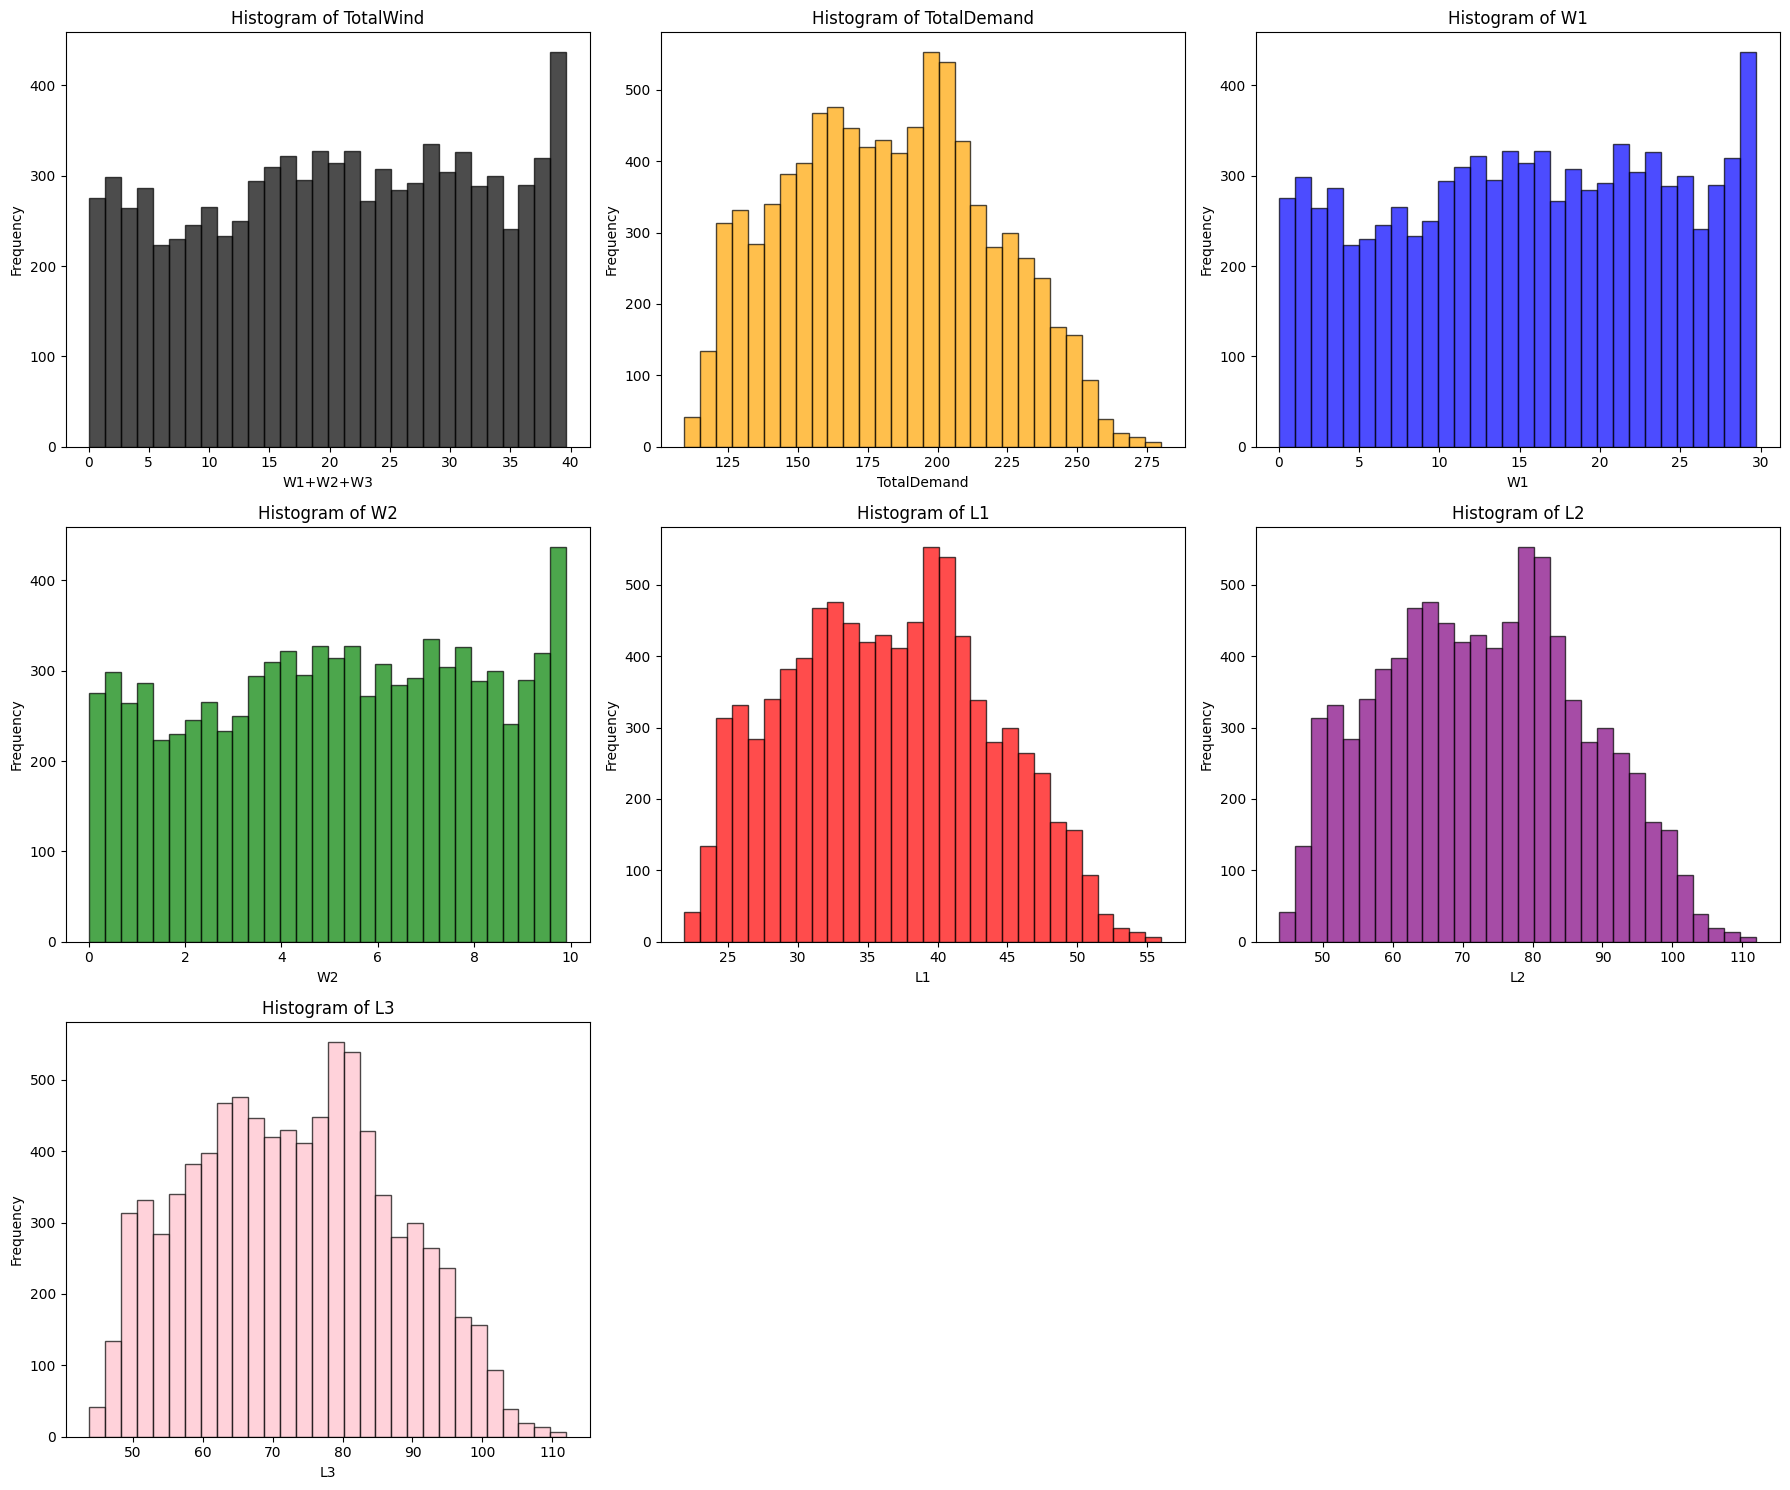

In [15]:
# Plot histograms for the wind and load samples
plt.figure(figsize=(18, 15))

# Histogram of Total Wind
plt.subplot(3, 3, 1)
plt.hist(datafeatures['TotalWind'], bins=30, alpha=0.7, color='black', edgecolor='black')
plt.title('Histogram of TotalWind')
plt.xlabel('W1+W2+W3')
plt.ylabel('Frequency')

# Histogram of Total Load
plt.subplot(3, 3, 2)
plt.hist(datafeatures['TotalDemand'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of TotalDemand')
plt.xlabel('TotalDemand')
plt.ylabel('Frequency')

# Histogram of W1
plt.subplot(3, 3, 3)
plt.hist(datafeatures['W1'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of W1')
plt.xlabel('W1')
plt.ylabel('Frequency')

# Histogram of W2
plt.subplot(3, 3, 4)
plt.hist(datafeatures['W2'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of W2')
plt.xlabel('W2')
plt.ylabel('Frequency')

# Histogram of L1
plt.subplot(3, 3, 5)
plt.hist(datafeatures['L1'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of L1')
plt.xlabel('L1')
plt.ylabel('Frequency')

# Histogram of L2
plt.subplot(3, 3, 6)
plt.hist(datafeatures['L2'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Histogram of L2')
plt.xlabel('L2')
plt.ylabel('Frequency')

# Histogram of L3
plt.subplot(3, 3, 7)
plt.hist(datafeatures['L3'], bins=30, alpha=0.7, color='pink', edgecolor='black')
plt.title('Histogram of L3')
plt.xlabel('L3')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

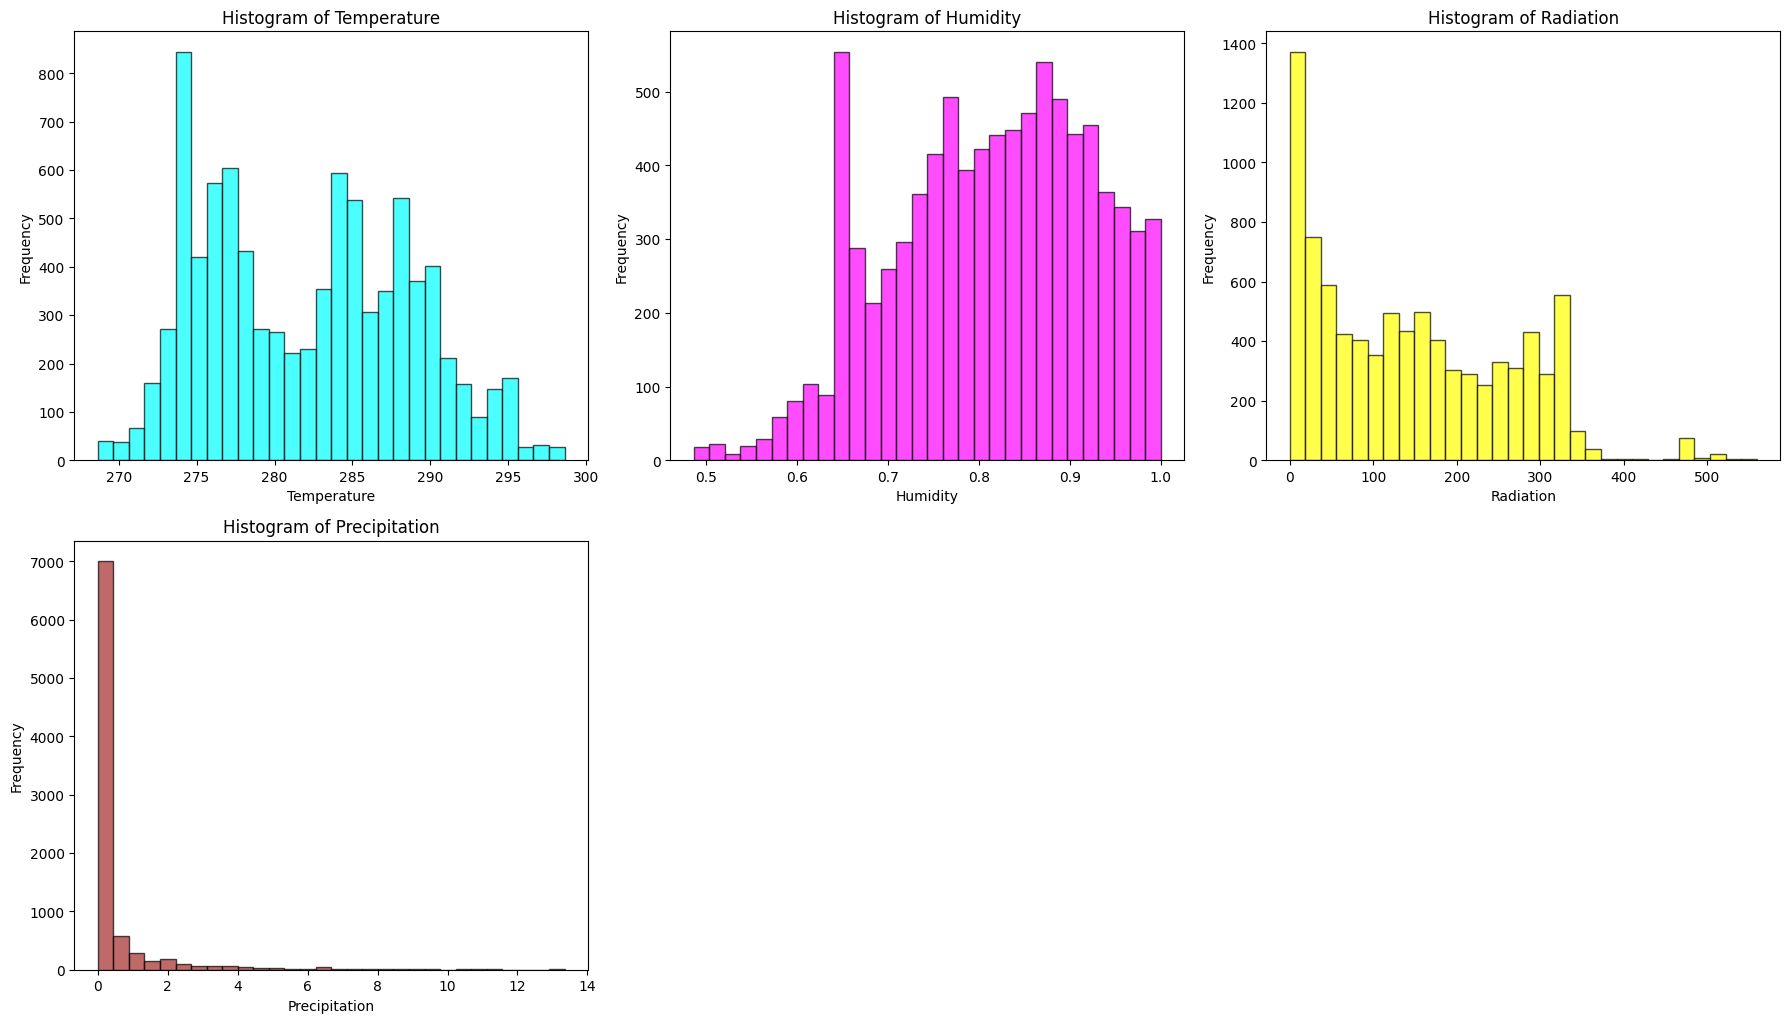

In [16]:
# Plot histograms for the wind, load samples, and weather variables
plt.figure(figsize=(18, 15))

# Histogram of Temperature
plt.subplot(3, 3, 1)
plt.hist(datafeatures['temperature'], bins=30, alpha=0.7, color='cyan', edgecolor='black')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram of Humidity
plt.subplot(3, 3, 2)
plt.hist(datafeatures['humidity'], bins=30, alpha=0.7, color='magenta', edgecolor='black')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram of Radiation
plt.subplot(3, 3, 3)
plt.hist(datafeatures['radiation'], bins=30, alpha=0.7, color='yellow', edgecolor='black')
plt.title('Histogram of Radiation')
plt.xlabel('Radiation')
plt.ylabel('Frequency')

# Histogram of Precipitation
plt.subplot(3, 3, 4)
plt.hist(datafeatures['precipitation'], bins=30, alpha=0.7, color='brown', edgecolor='black')
plt.title('Histogram of Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Time Series dynamics

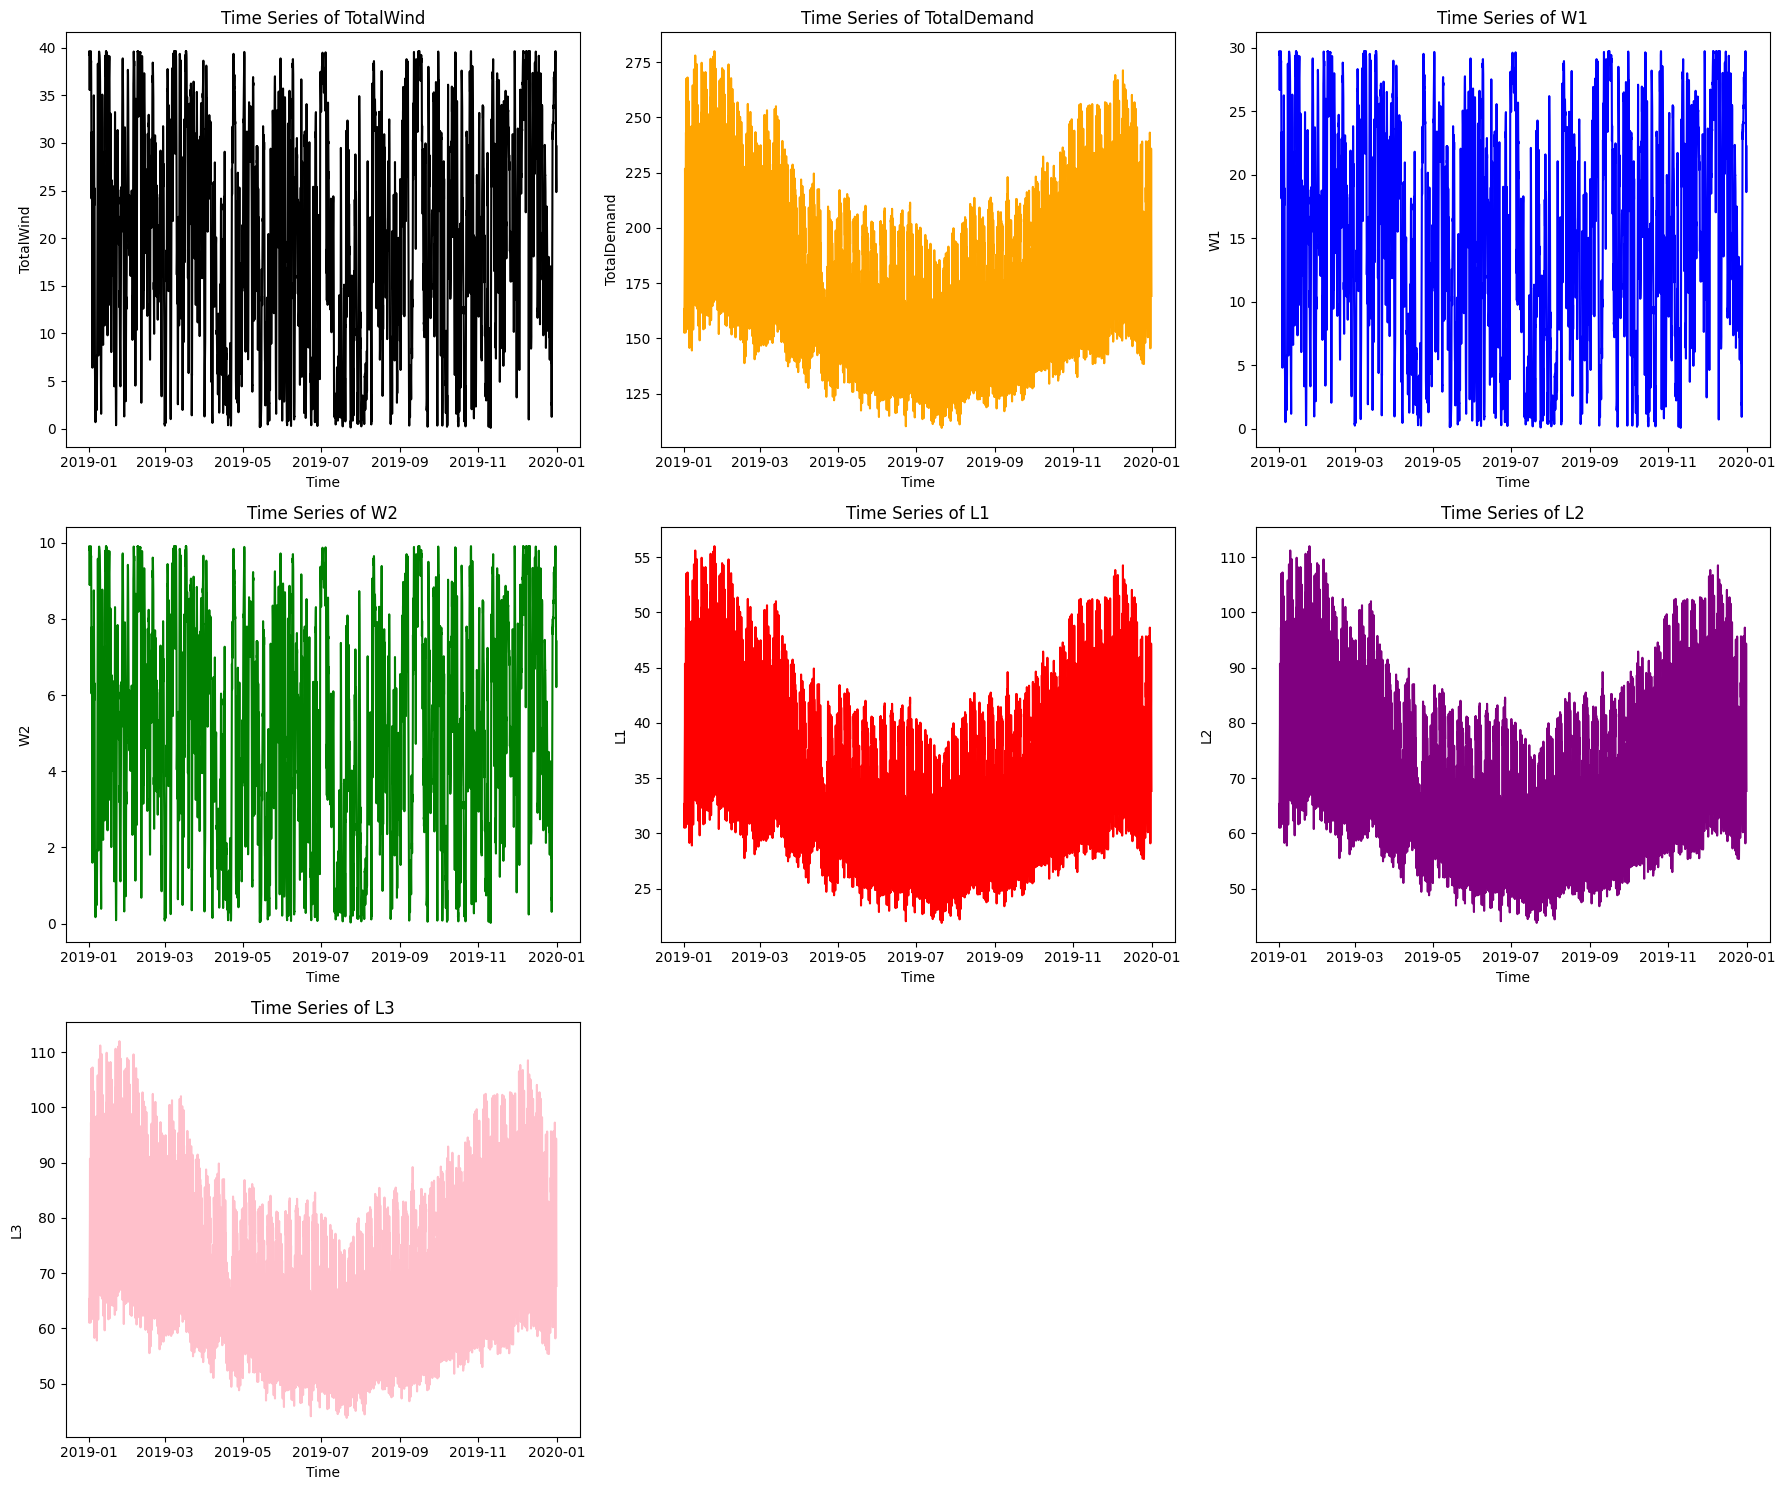

In [17]:
# Plot time series for the wind and load samples
plt.figure(figsize=(18, 15))

# Time series of Total Wind
plt.subplot(3, 3, 1)
plt.plot(datafeatures['ts'], datafeatures['TotalWind'], color='black')
plt.title('Time Series of TotalWind')
plt.xlabel('Time')
plt.ylabel('TotalWind')

# Time series of Total Load
plt.subplot(3, 3, 2)
plt.plot(datafeatures['ts'], datafeatures['TotalDemand'], color='orange')
plt.title('Time Series of TotalDemand')
plt.xlabel('Time')
plt.ylabel('TotalDemand')

# Time series of W1
plt.subplot(3, 3, 3)
plt.plot(datafeatures['ts'], datafeatures['W1'], color='blue')
plt.title('Time Series of W1')
plt.xlabel('Time')
plt.ylabel('W1')

# Time series of W2
plt.subplot(3, 3, 4)
plt.plot(datafeatures['ts'], datafeatures['W2'], color='green')
plt.title('Time Series of W2')
plt.xlabel('Time')
plt.ylabel('W2')

# Time series of L1
plt.subplot(3, 3, 5)
plt.plot(datafeatures['ts'], datafeatures['L1'], color='red')
plt.title('Time Series of L1')
plt.xlabel('Time')
plt.ylabel('L1')

# Time series of L2
plt.subplot(3, 3, 6)
plt.plot(datafeatures['ts'], datafeatures['L2'], color='purple')
plt.title('Time Series of L2')
plt.xlabel('Time')
plt.ylabel('L2')

# Time series of L3
plt.subplot(3, 3, 7)
plt.plot(datafeatures['ts'], datafeatures['L3'], color='pink')
plt.title('Time Series of L3')
plt.xlabel('Time')
plt.ylabel('L3')

plt.tight_layout()
plt.show()


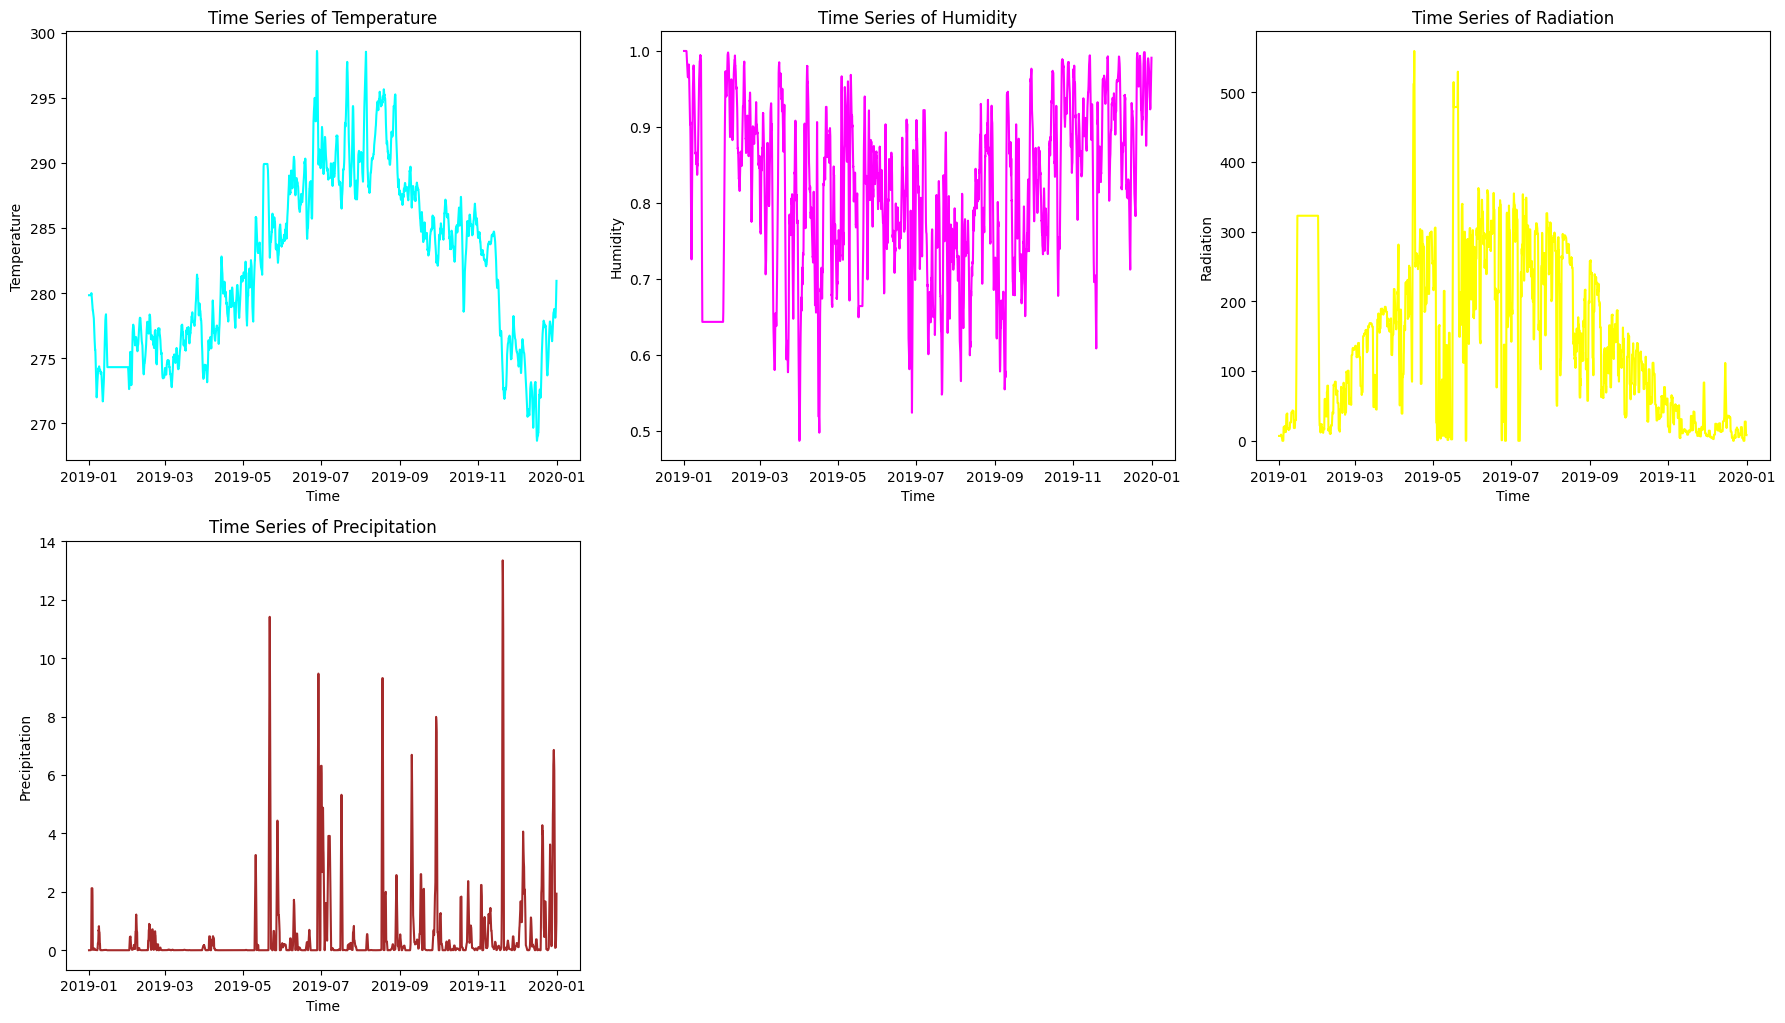

In [18]:
# Plot time series for the weather variables
plt.figure(figsize=(18, 15))

# Time series of Temperature
plt.subplot(3, 3, 1)
plt.plot(datafeatures['ts'], datafeatures['temperature'], color='cyan')
plt.title('Time Series of Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')

# Time series of Humidity
plt.subplot(3, 3, 2)
plt.plot(datafeatures['ts'], datafeatures['humidity'], color='magenta')
plt.title('Time Series of Humidity')
plt.xlabel('Time')
plt.ylabel('Humidity')

# Time series of Radiation
plt.subplot(3, 3, 3)
plt.plot(datafeatures['ts'], datafeatures['radiation'], color='yellow')
plt.title('Time Series of Radiation')
plt.xlabel('Time')
plt.ylabel('Radiation')

# Time series of Precipitation
plt.subplot(3, 3, 4)
plt.plot(datafeatures['ts'], datafeatures['precipitation'], color='brown')
plt.title('Time Series of Precipitation')
plt.xlabel('Time')
plt.ylabel('Precipitation')

plt.tight_layout()
plt.show()

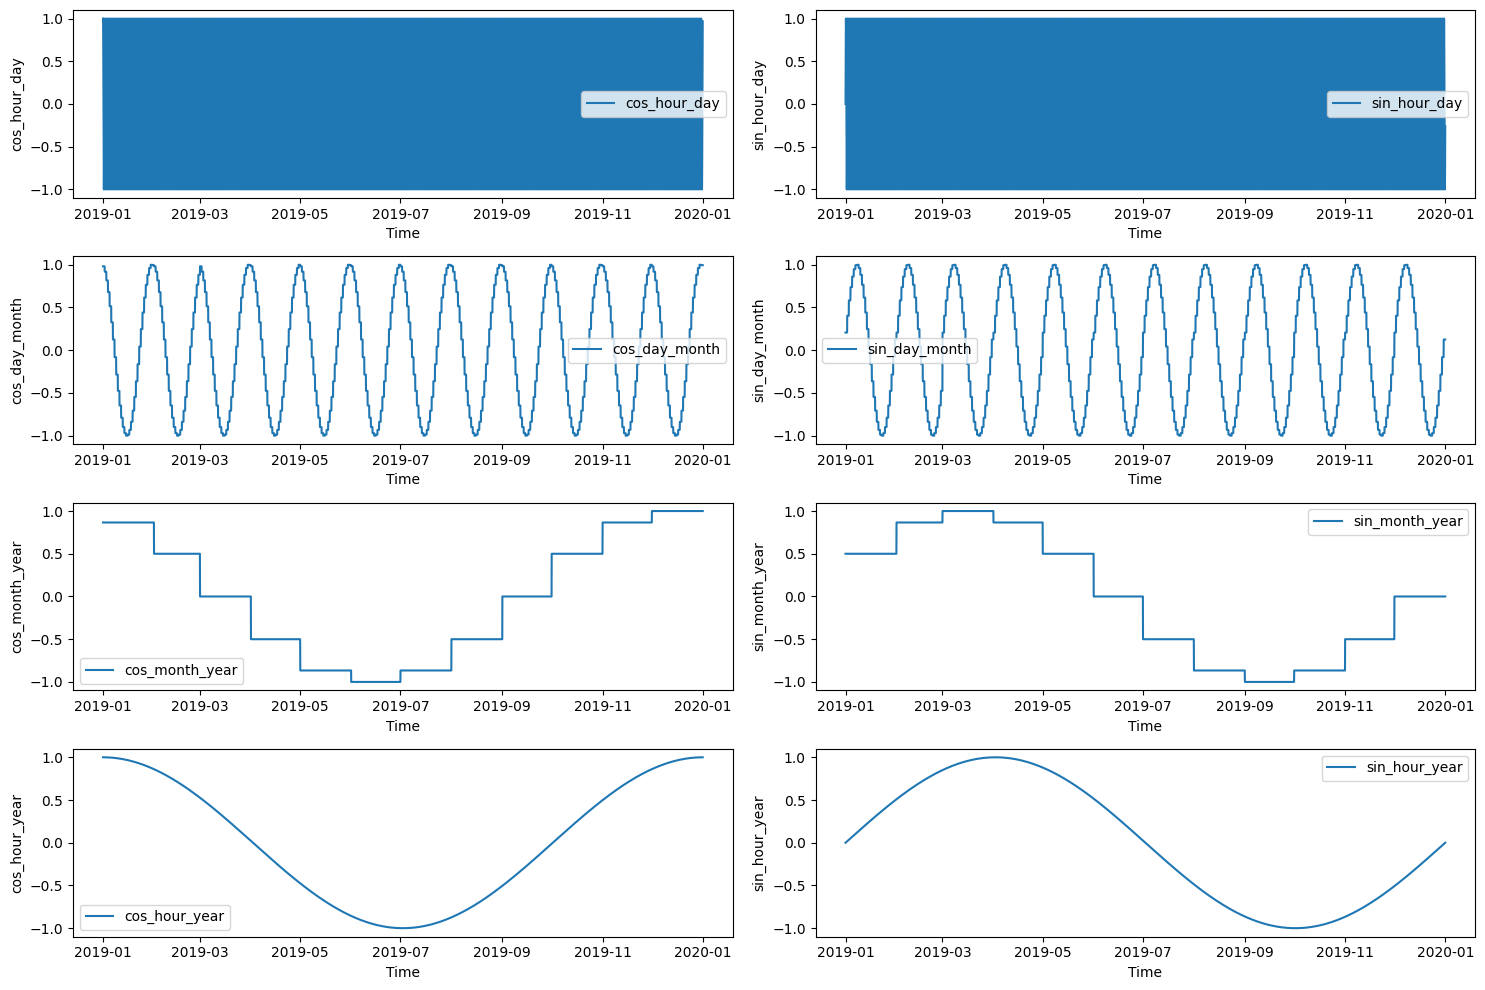

In [19]:
# Seasonal decomposition of the time series
plt.figure(figsize=(15, 10))

plt.subplot(4, 2, 1)
plt.plot(datafeatures['ts'], datafeatures['cos_hour_day'], label='cos_hour_day')
plt.xlabel('Time')
plt.ylabel('cos_hour_day')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(datafeatures['ts'], datafeatures['sin_hour_day'], label='sin_hour_day')
plt.xlabel('Time')
plt.ylabel('sin_hour_day')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(datafeatures['ts'], datafeatures['cos_day_month'], label='cos_day_month')
plt.xlabel('Time')
plt.ylabel('cos_day_month')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(datafeatures['ts'], datafeatures['sin_day_month'], label='sin_day_month')
plt.xlabel('Time')
plt.ylabel('sin_day_month')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(datafeatures['ts'], datafeatures['cos_month_year'], label='cos_month_year')
plt.xlabel('Time')
plt.ylabel('cos_month_year')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(datafeatures['ts'], datafeatures['sin_month_year'], label='sin_month_year')
plt.xlabel('Time')
plt.ylabel('sin_month_year')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(datafeatures['ts'], datafeatures['cos_hour_year'], label='cos_hour_year')
plt.xlabel('Time')
plt.ylabel('cos_hour_year')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(datafeatures['ts'], datafeatures['sin_hour_year'], label='sin_hour_year')
plt.xlabel('Time')
plt.ylabel('sin_hour_year')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
output_path = Path(r'.\Inputs\Processed\datafeatures.csv')
datafeatures.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame saved to Inputs\Processed\datafeatures.csv


# OPTIMIZATION

In [30]:
import sys
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas import DataFrame

warnings.simplefilter(action='ignore')

# Plot settings
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.'
plt.rcParams['grid.linewidth'] = 0.4


class unit_comitment():

    def __init__(self):

        ## Uploading the input data
        # B-matrix
        self.B = pd.read_csv('./Inputs/B (power transfer factor of each bus to each line).csv', sep=';')

        # Capacity of wind farms
        self.wfc = pd.read_csv('./Inputs/Capacity of wind farms.csv', sep=';')['wind'].tolist()
        # Loads
        self.loads = pd.read_csv('./Inputs/Loads.csv', sep=';')['load'].tolist()
        # Pmax of conv gens
        self.pg_max = pd.read_csv('./Inputs/Maximum production of generating units.csv', sep=';')['pgmax'].tolist()
        # Pmin of conv gens
        self.pg_min = pd.read_csv('./Inputs/Minimum production of generating units.csv', sep=';')['pgmin'].tolist()
        # Min gen downtime
        self.pg_min_downtimes = pd.read_csv('./Inputs/Minimum down time of generating units.csv', sep=';')['ld'].tolist()
        # Min gen uptime
        self.pg_min_uptimes = pd.read_csv('./Inputs/Minimum up time of generating units.csv', sep=';')['lu'].tolist()
        # Production costs of gen units
        self.g_costs = pd.read_csv('./Inputs/Production cost of generating units.csv', sep=';')['cost_op'].tolist()
        # Ramping rate of gen units
        self.ramp_rates = pd.read_csv('./Inputs/Ramping rate of generating units.csv', sep=';')['ru'].tolist()

        # Start-up costs
        self.startup_costs = pd.read_csv('./Inputs/Start-up cost of generating units.csv', sep=';')['cost_st'].tolist()
        # Line transmission capacities
        self.transmission_caps = pd.read_csv('./Inputs/Transmission capacity of lines.csv', sep=';')['fmax'].tolist()

        # WF, gen, and load position in the system. starts with 0!
        self.gen_idx = [0, 1, 5] #-> node idx where there is a conv gen
        self.wf_idx  = [3, 4]
        self.ld_idx  = [3, 4, 5]

        # Defining the lengths of the sets we are working with
        self.T = 24  # time span in hrs
        self.N = 6 # Number of busses in the system
        self.GC = len(self.gen_idx) # conv generator number
        self.WF = len(self.wf_idx)  # Number of wind farms
        self.G = self.GC + self.WF # all generators

        self.L = len(self.loads)  # Loads
        self.lines = len(self.transmission_caps) # total number of lines in the system

        self.M = 1e5 # penalization term for the slack variables in the objective function

        # processed input data:
        self.data_features = pd.read_csv('./Inputs/Processed/datafeatures.csv', sep=',', decimal='.')

        # wind turbine 24hr-production forecast
        self.wf_power = pd.read_csv('./Inputs/wind_data.csv', sep = ';')

        # system demand over 24 hrs on each bus:
        self.demand = pd.read_csv('./Inputs/demand_data.csv', sep=';')

        # mapping generators & WF to nodes: a dict of nodes, each pointing to a list of generators, connected there
        # all are zero indexed !
        # nodes : [0 ... 6] ; gen : [0..3]
        # {node0 : [gen0]}
        self.gen_nodes = {0:[0], 1:[1], 2:[] , 3:[3], 4:[4], 5:[2]}
        self.wind_nodes = {0:[], 1:[], 2:[] , 3:[0], 4:[1], 5:[]}
        self.load_nodes = {0:[], 1:[], 2:[] , 3:[3], 4:[4], 5:[5]}

        # Status of conv. gens @ T = -1 : are the gens on before the start of the model
        a = 1
        self.u1_0 = a
        self.u2_0 = a
        self.u3_0 = a
        self.u4_0 = a
        self.u5_0 = a

    def print_items(self):
        for attr, value in self.__dict__.items():
            print(f"{attr}:\n {value}\n")

    def solve_model(self):
        ## Set up the model

        direction = gb.GRB.MINIMIZE  # Min the cost
        m = gb.Model()  # Create a Gurobi model
        m.setParam('OutputFlag', 0)  # 1 == detailed output for debugging

        # ========================================= Decision Variables ============================================
        p = m.addVars(self.G, self.T, lb=0, ub=gb.GRB.INFINITY, name="p")  ## gen / wf g dispatch at time t
        s = m.addVars(self.G, self.T, lb=0, ub=gb.GRB.INFINITY, name="s")
        u = m.addVars(self.G, self.T, vtype=gb.GRB.BINARY, name="u") # binary variables for on/off status of generators

        # Slacks:
        e = m.addVars(self.N, self.T, lb=0, ub=gb.GRB.INFINITY, name="e")
        d = m.addVars(self.N, self.T, lb=0, ub=gb.GRB.INFINITY, name="d")

        # ========================================= Objective Function ============================================
        obj = gb.quicksum( (self.g_costs[g] * p[g, t] + s[g, t]) for g in range(self.G) for t in range(self.T)) \
              + self.M*gb.quicksum(e[n, t] + d[n, t] for n in range(self.N) for t in range(self.T)) ## WF costs are 0

        m.setObjective(obj, direction)

        # ========================================= Balancing Equation ============================================
        for t in range(self.T):
            m.addConstr((gb.quicksum(p[g, t] for g in range(self.G)) ==
            gb.quicksum(self.demand.iloc[t, n] + e[n, t] - d[n, t] for n in range(self.N))), name=f'BALANCE_{t}')

        # ======================================== Generator limits ==============================================
        m.addConstrs(u[g, t] * self.pg_min[g] <= p[g, t] for g in range(self.G) for t in range(self.T))
        m.addConstrs(u[g, t] * self.pg_max[g] >= p[g, t] for g in range(self.G) for t in range(self.T))

        m.addConstrs((p[self.GC + g, t] <= self.wf_power.iloc[t, g] for g in range(self.WF) for t in range(self.T)), name='Wind')

        # ========================================= Line Flow Limits ==============================================
        for t in range(self.T): # for each time
            for n in range(self.N): # for each node
                for l in range(self.lines): # for each line
                    m.addConstr(gb.quicksum(self.B.iloc[l, n] * (p[g, t] - self.demand.iloc[t, n] - e[n, t] + d[n, t])
                                            for g in self.gen_nodes.get(n)) <= self.transmission_caps[l], name = f'FLow_{t}{n}{l}_max')
                    m.addConstr(gb.quicksum(self.B.iloc[l, n] * (p[g, t] - self.demand.iloc[t, n] - e[n, t] + d[n, t])
                                            for g in self.gen_nodes.get(n)) >= -self.transmission_caps[l], name = f'FLow_{t}{n}{l}_min')

        # ========================================= Initial state of the generators ===========================================
        m.addConstr(u[0, 0] == self.u1_0)
        m.addConstr(u[1, 0] == self.u2_0)
        m.addConstr(u[2, 0] == self.u3_0)
        m.addConstr(u[3, 0] == self.u4_0)
        m.addConstr(u[4, 0] == self.u5_0)

        # ========================================= Startup Cost Constr. ===========================================
        m.addConstrs(s[g, t] >= self.startup_costs[g] * (u[g, t] - u[g, t-1]) for g in range(self.G) for t in range(1, self.T))
        m.addConstrs(s[g, t] >= 0 for g in range(self.G) for t in range(self.T))

        # ========================================= Ramping Constr. ================================================
        m.addConstrs(p[g, t] - p[g, t-1] <= self.ramp_rates[g] for g in range(self.G) for t in range(1, self.T))
        m.addConstrs(p[g, t-1] - p[g, t] <= self.ramp_rates[g] for g in range(self.G) for t in range(1, self.T))

        # ========================================= Min Up/Down Time =============================================

        for g in range(self.G):
            for t in range(1, self.T-max(self.pg_min_uptimes)):
                for tau in range(t, self.pg_min_uptimes[g] + t - 1):
                    m.addConstr(-u[g, t - 1] + u[g, t] - u[g, tau] <= 0)

            for t in range(1, self.T - max(self.pg_min_downtimes)):
                for tau in range(t, self.pg_min_downtimes[g] + t - 1):
                    m.addConstr(u[g, t - 1] - u[g, t] + u[g, tau] <= 1)


        #================================================ Solve  =============================================
        m.update()
        #m.write('unit_comittment_model.lp')
        m.optimize()

        # Satus
        self.print_status(m)

        #================================================ Results  =============================================
        columns = []
        columns.append('Time')

        # Record dispatched power
        for g in range(self.G):
            columns.append(f'gen{g+1}')

        columns.append('total_load')
        columns.append('total_dispatch')

        # Record startup costs
        for g in range(self.G):
            columns.append(f's{g+1}')

        # Record binaries
        for g in range(self.G):
            columns.append(f'u{g+1}')

        # Record sacks
        for n in range(self.N):
            columns.append(f'e{n + 1}')
        for n in range(self.N):
            columns.append(f'd{n + 1}')

        results = pd.DataFrame(columns=columns)

        ## Record for each t
        t_result = {}
        for t in range(self.T):
            #t_result['Time'] = t
            # record dispatch
            sum = 0
            for g in range(self.G):
                t_result[f'gen{g+1}'] = p[g, t].x
                sum += p[g, t].x

            # sum of dispatch
            t_result['total_dispatch'] = sum
            # record load @ t
            t_result['total_load'] = self.demand.iloc[t, :].sum()

            # s
            for g in range(self.G):
                t_result[f's{g+1}'] = s[g, t].x
            for g in range(self.G):
                t_result[f'u{g+1}'] = u[g, t].x

            # record slack
            for n in range(self.N):
                t_result[f'e{n+1}'] = e[n, t].x
            for n in range(self.N):
                t_result[f'd{n + 1}'] = d[n, t].x

            results.loc[len(results)] = t_result

        #print(results.head(50).to_string())
        print('--'*50, 'Model solved', '--'*50)

        return results

    def plot_results(self, results:pd.DataFrame, hour:int):

        disp = results[['gen1', 'gen2', 'gen3', 'gen4', 'gen5']].copy(deep=True)
        all = results[['gen1', 'gen2', 'gen3', 'gen4', 'gen5', 'total_load']].copy(deep=True)
        capacity = self.pg_max

        # WF max power @ hout t is the forecast. The WFs can be down-regulated, if necessary
        capacity[3] = self.wf_power.iloc[hour, 0]
        capacity[4] = self.wf_power.iloc[hour, 1]

        fig, (ax1) = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
        fig.suptitle(f'Optimal Dispatch. t = {hour}')

        df = disp.T
        total_load = all['total_load'][hour].round(2)
        ax1.bar(df.index, df.iloc[:,hour], label='Gen_Dispatch', width=0.4)
        ax1.bar(df.index, capacity, label = 'Max Capacity &\nPredicted WF Power', width = 0.4, edgecolor='black', linestyle='--', fill=False)
        ax1.text(x=3, y=150, s=f'Total load={total_load}MW', fontsize=8, ha='center', va='center',
                bbox=dict(facecolor='blue', alpha=0.5))

        ax1.set_xticklabels(['G1', 'G2', 'G3', 'WF1', 'WF2'])
        ax1.set_ylabel('Dispatched Power [MW]')
        ax1.legend(fontsize = 7)

        plt.savefig(f'./figures/opt_dispatch_t={hour}.png')
        #plt.show()

    def print_status(self, m):
        status = m.status
        if status == gb.GRB.OPTIMAL:
            print("Optimal solution found:", m.objVal)
        elif status == gb.GRB.INFEASIBLE:
            print("Model is infeasible")
        elif status == gb.GRB.UNBOUNDED:
            print("Model is unbounded")
        elif status == gb.GRB.ITERATION_LIMIT:
            print("Optimization terminated because the total number of simplex iterations performed exceeded the limit")
        elif status == gb.GRB.NODE_LIMIT:
            print(
                "Optimization terminated because the total number of branch-and-cut nodes explored exceeded the limit")
        elif status == gb.GRB.TIME_LIMIT:
            print("Optimization terminated because the time expended exceeded the limit")
        elif status == gb.GRB.SOLUTION_LIMIT:
            print("Optimization terminated because the number of solutions found reached the limit")
        elif status == gb.GRB.INTERRUPTED:
            print("Optimization was terminated by the user")
        elif status == gb.GRB.NUMERIC:
            print("Optimization was terminated due to unrecoverable numerical difficulties")
        elif status == gb.GRB.SUBOPTIMAL:
            print("Unable to satisfy optimality tolerances; a sub-optimal solution is available")
        elif status == gb.GRB.INPROGRESS:
            print("Asynchronous optimization call was made, but the associated optimization run is not yet complete")
        elif status == gb.GRB.INF_OR_UNBD:
            print("Model is either infeasible or unbounded")
        else:
            print(f"Optimization status: {status}")




In [ ]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')

# Plot settings
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.'
plt.rcParams['grid.linewidth'] = 0.4


##  Solves the model with 'load_samples.csv' and 'wind_samples.csv'
step = 400
solve = 1
if solve:
    # initialize class:
    uc = unit_comitment()

    # read the data needed for optimization:
    uc.data_features = pd.read_csv('./Inputs/Processed/datafeatures.csv', sep=',', decimal='.')
    #uc.data_features = uc.data_features.loc[0:step]

    uc.data_features.reset_index(inplace=True)

    # length of the df
    uc.T = len(uc.data_features['ts'])

    # Number of busses:
    uc.N = 6

    # demand
    uc.demand = pd.DataFrame(np.zeros((uc.T, uc.N)), columns=['L1', 'L2', 'L3', 'L4', 'L5', 'L6'])

    uc.demand = uc.demand.reindex(uc.data_features.index)
    uc.demand[['L4', 'L5', 'L6']] = uc.data_features[['L1', 'L2', 'L3']]

    # wind power
    uc.wf_power = uc.data_features.loc[:, ['W1', 'W2']]

    # solve
    result = uc.solve_model()
    result.to_csv('./Inputs/Processed/result_optim.csv', index=False, sep = ';')

    result = pd.concat([uc.data_features, result], axis=1)

    #print(result.to_string())
    #result.to_csv('./Inputs/Processed/model_data_all_features.csv', index = False, sep = ';')





Optimal solution found: 1396674.8964115563
---------------------------------------------------------------------------------------------------- Model solved ----------------------------------------------------------------------------------------------------


In [39]:
print(result.head(10).to_string())

   index                   ts  wind_speed  TotalDemand  TotalWind     W1    W2         L1         L2         L3  cos_hour_day  sin_hour_day  cos_day_month  sin_day_month  cos_month_year  sin_month_year  cos_hour_year  sin_hour_year                 hour  temperature  humidity  wind_direction  radiation  precipitation  Time   gen1       gen2  gen3   gen4  gen5  total_load  total_dispatch   s1   s2   s3   s4   s5   u1   u2   u3   u4   u5   e1   e2   e3   e4   e5   e6   d1   d2   d3   d4   d5   d6
0      0  2019-01-01 00:00:00      15.424   163.284873      39.28  29.46  9.82  32.656975  65.313949  65.313949  1.000000e+00      0.000000       0.978717       0.205215        0.866025             0.5       1.000000       0.000000  2019-01-01 00:00:00    279.84314  1.000007       235.57857        7.0            0.0   NaN  100.0  14.004873  10.0  29.46  9.82  163.284873      163.284873  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1 

              ts  wind_speed  TotalDemand  TotalWind     W1    W2         L1         L2         L3  cos_hour_day  sin_hour_day  cos_day_month  sin_day_month  cos_month_year  sin_month_year  cos_hour_year  sin_hour_year  temperature  humidity  radiation  precipitation   gen1       gen2  gen3   gen4  gen5  s1  s2  s3  s4  s5  u1  u2  u3  u4  u5  e1  e2  e3  e4  e5  e6  d1  d2  d3  d4  d5  d6
0  1/1/2019 0:00      15.424   163.284873      39.28  29.46  9.82  32.656975  65.313949  65.313949  1.000000e+00      0.000000       0.978717       0.205215        0.866025             0.5       1.000000       0.000000          7.2     100.0        7.0            0.2  100.0  14.004873  10.0  29.46  9.82   0   0   0   0   0   1   1   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0
1  1/1/2019 1:00      16.318   159.968920      39.56  29.67  9.89  31.993784  63.987568  63.987568  9.659258e-01      0.258819       0.978717       0.205215        0.866025             0.5       1.000000       0.00

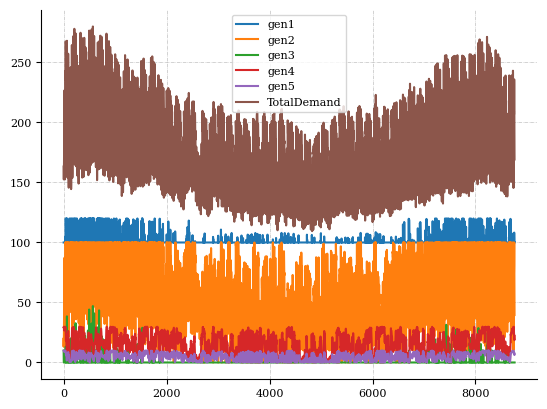

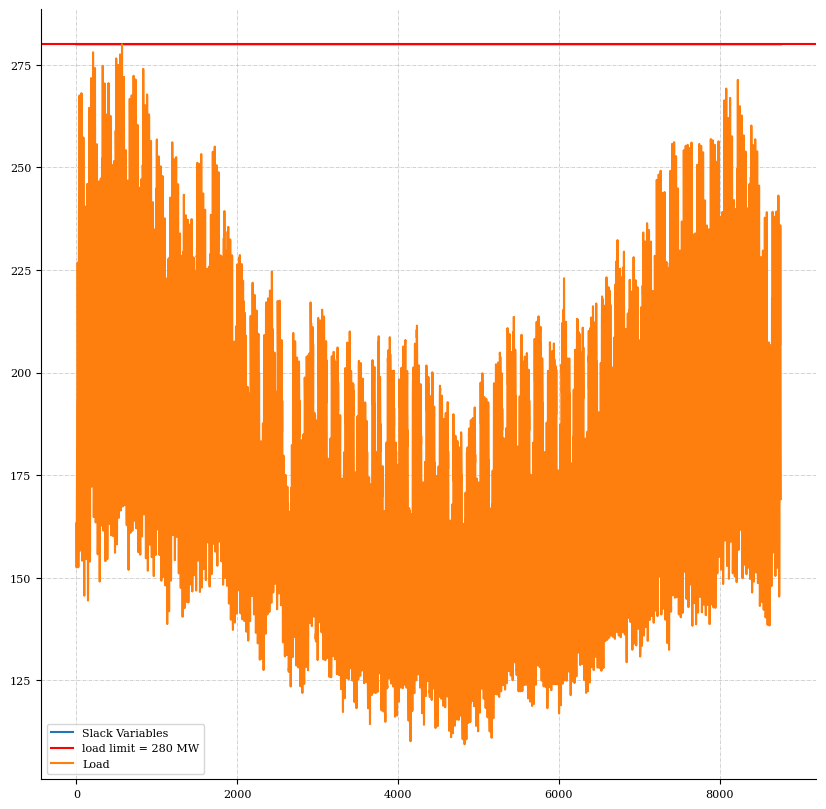

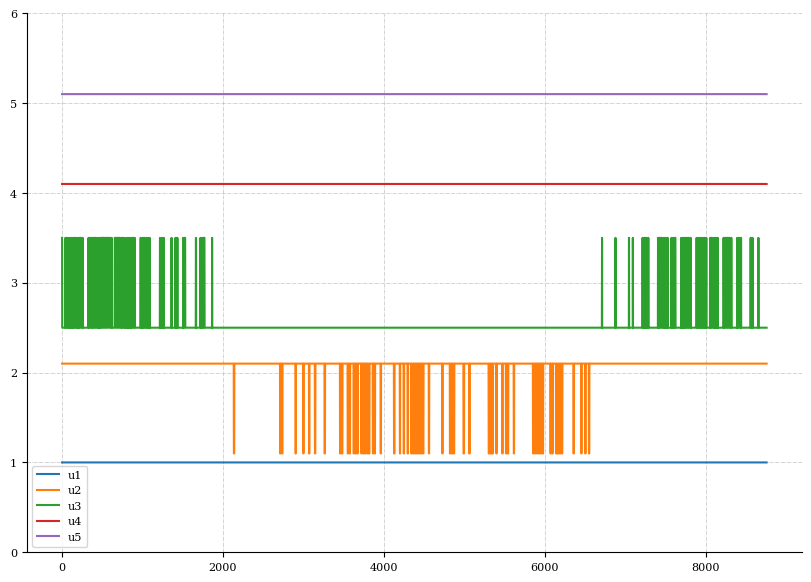

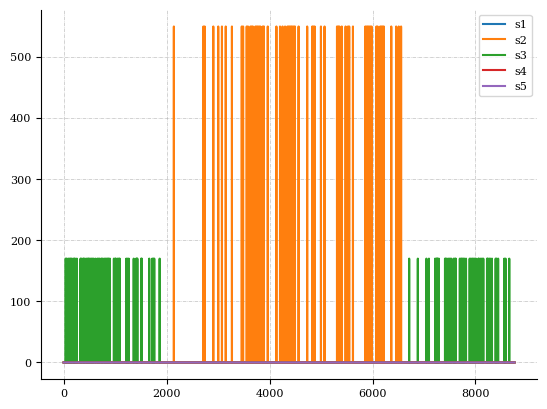

----------------------------------------------------------------------------------------------------
0 400


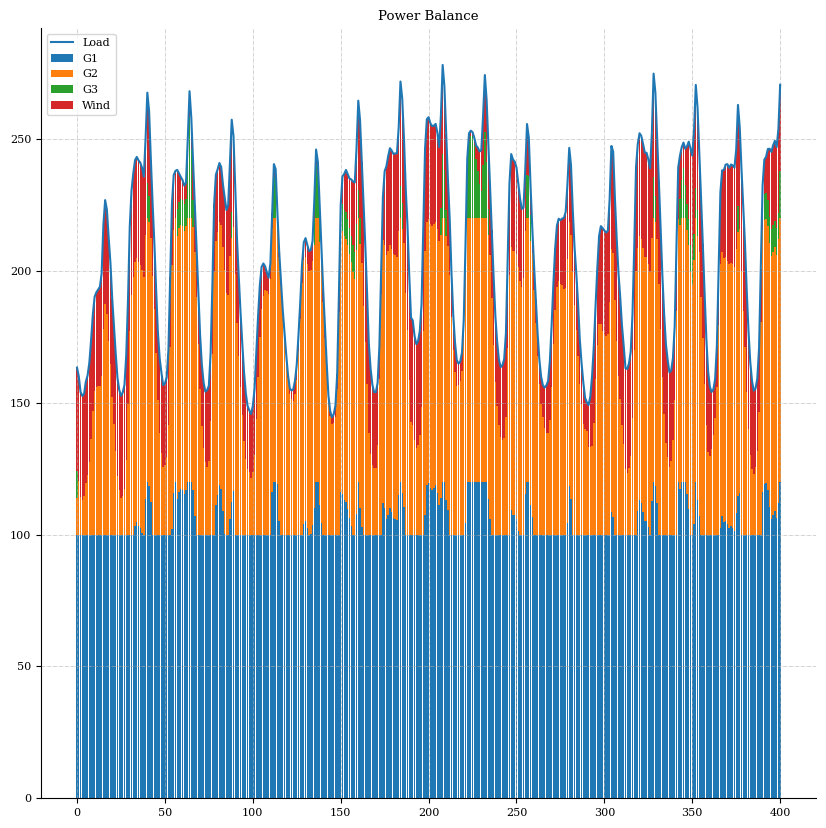

400 800


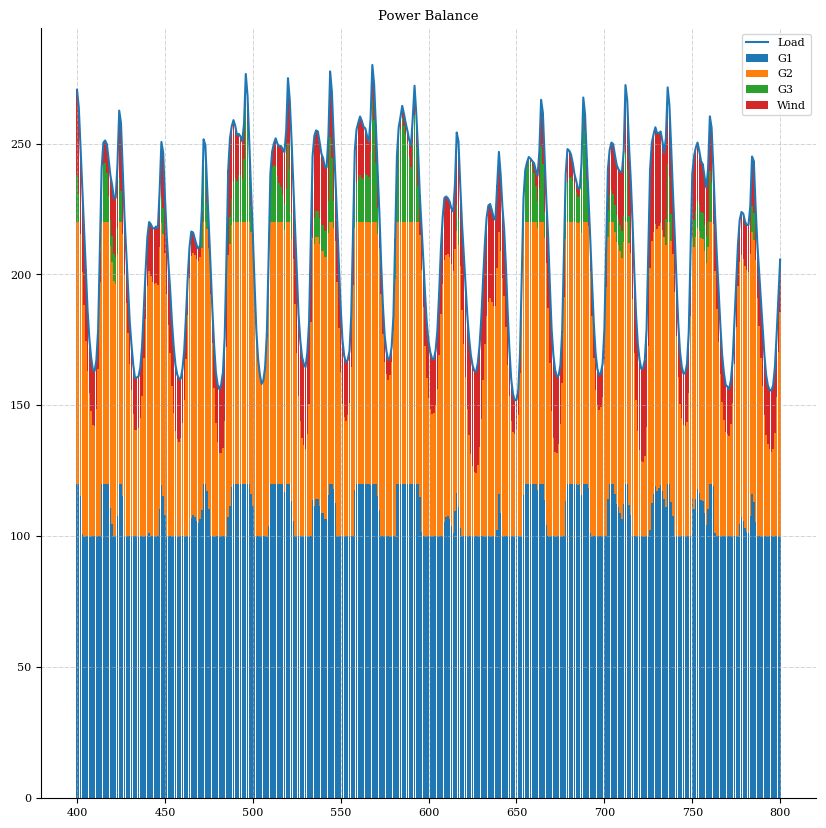

800 1200


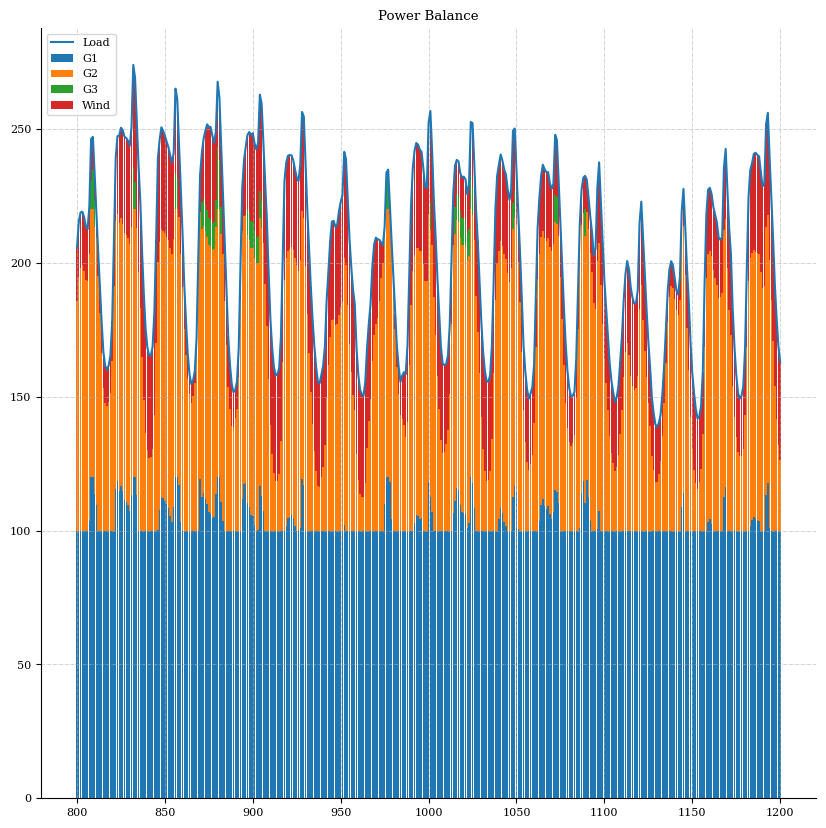

1200 1600


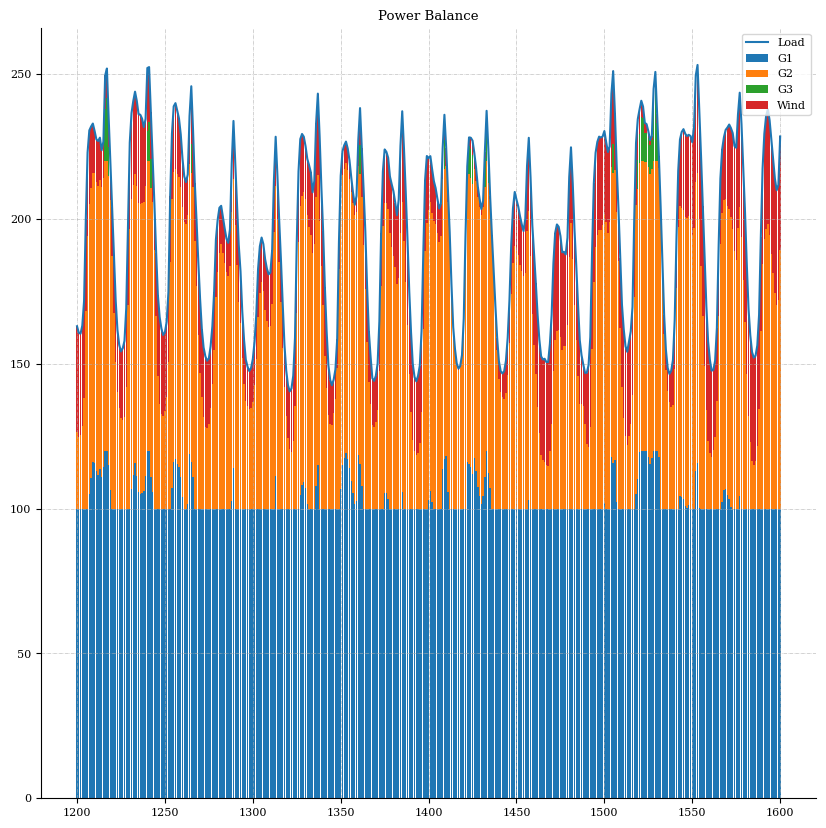

1600 2000


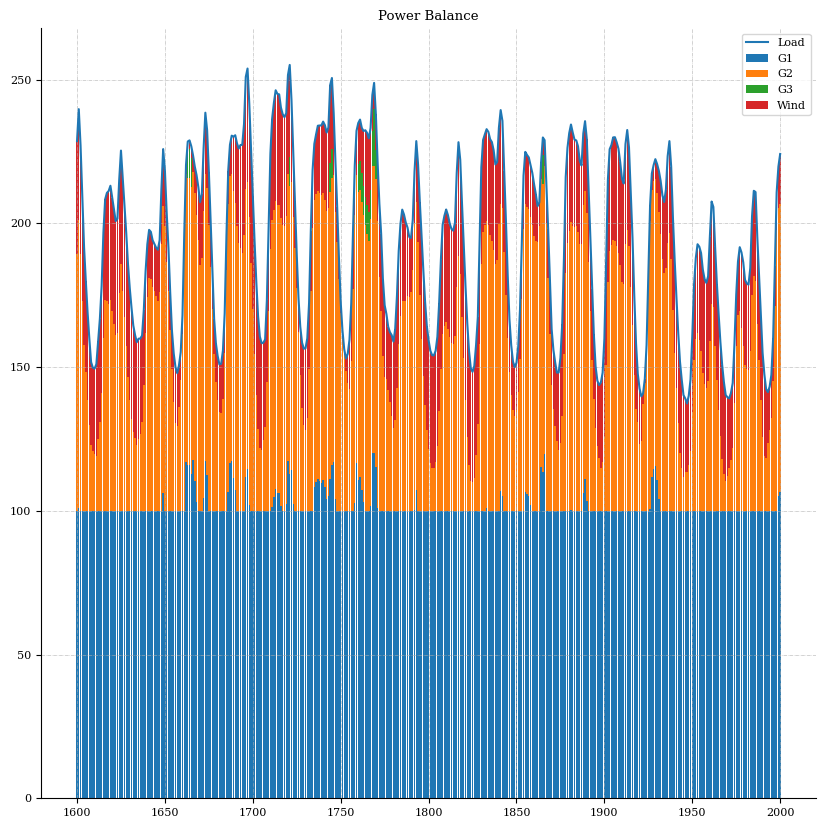

2000 2400


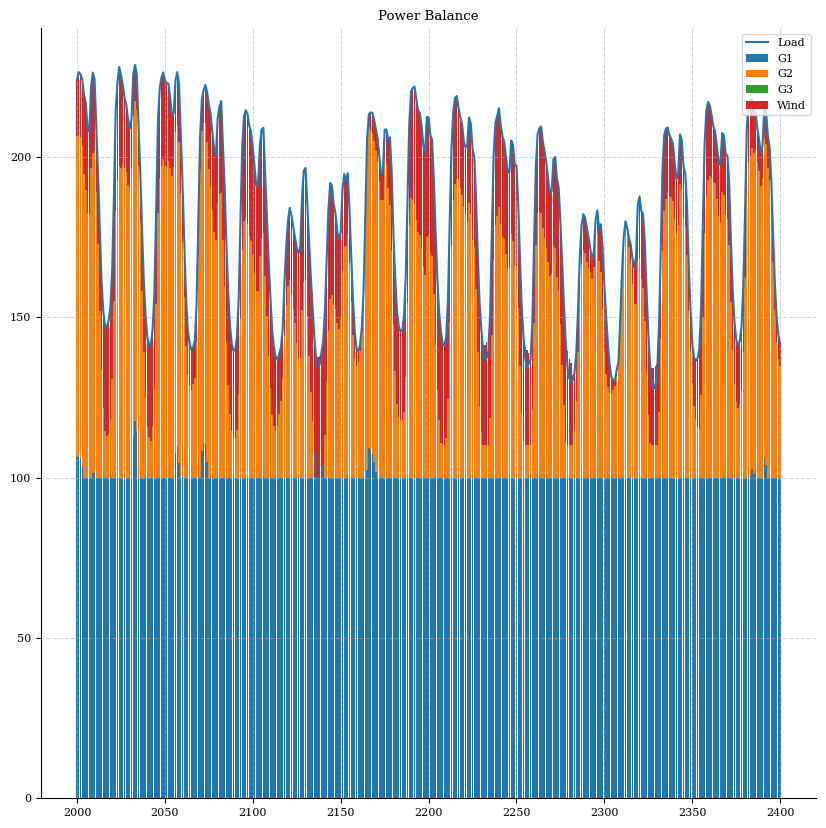

2400 2800


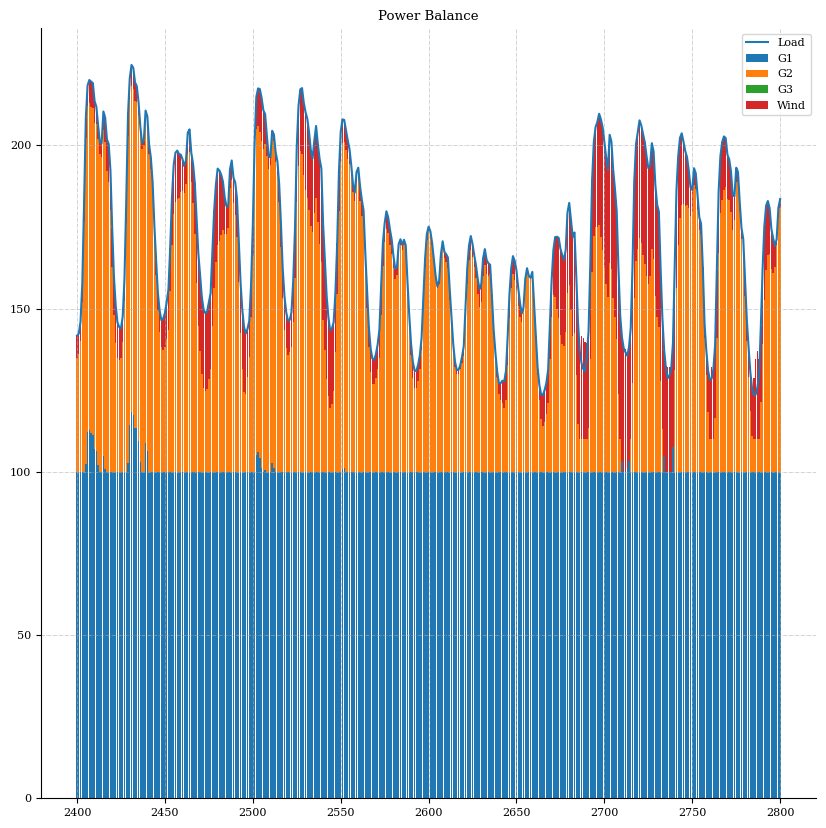

2800 3200


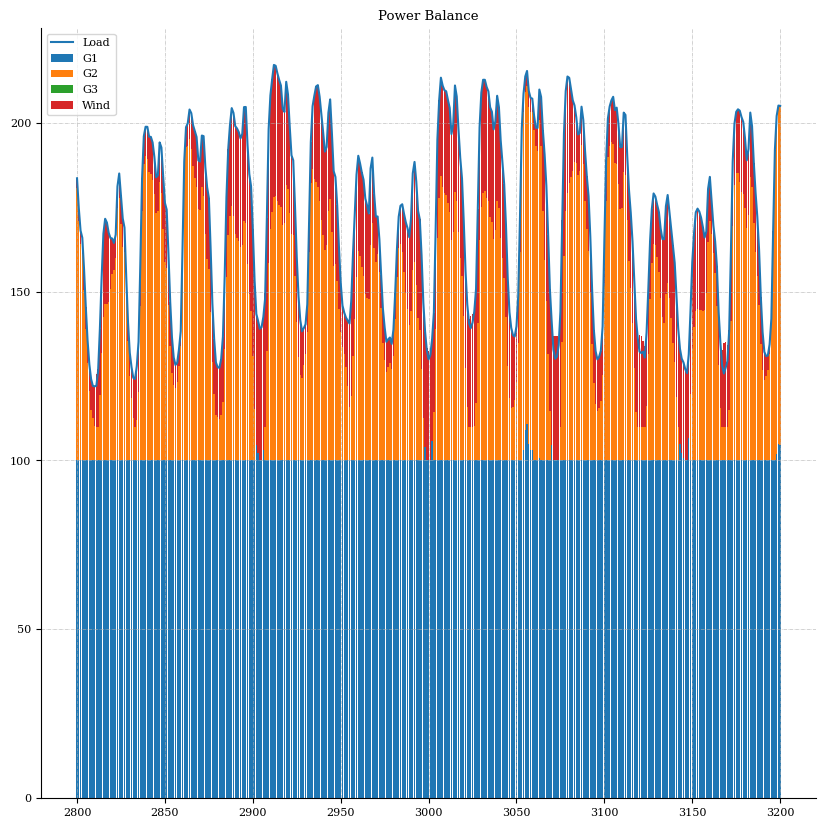

3200 3600


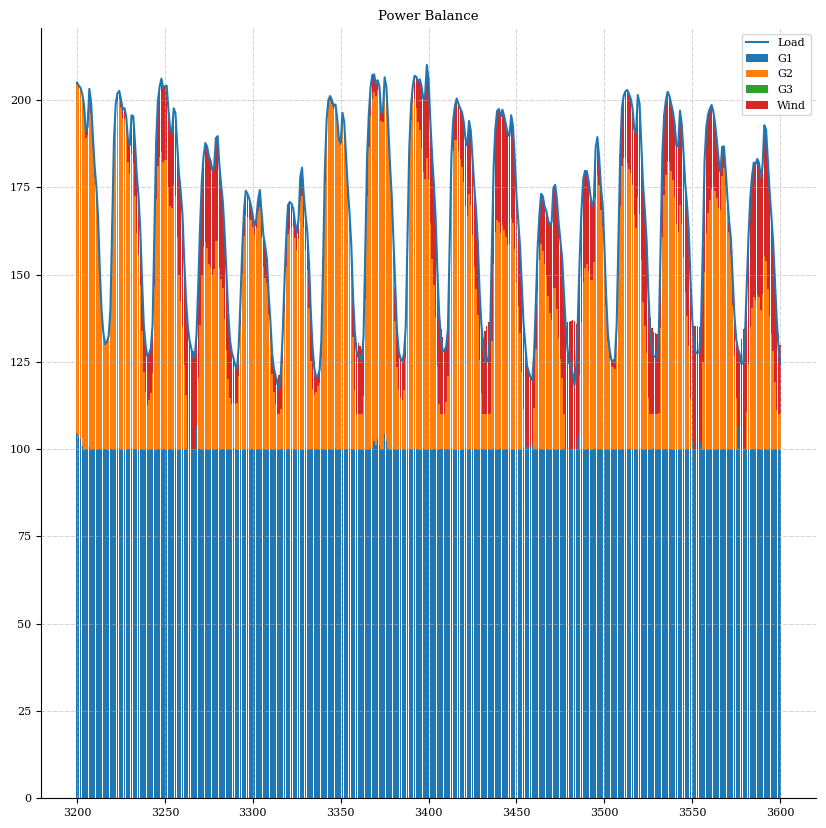

3600 4000


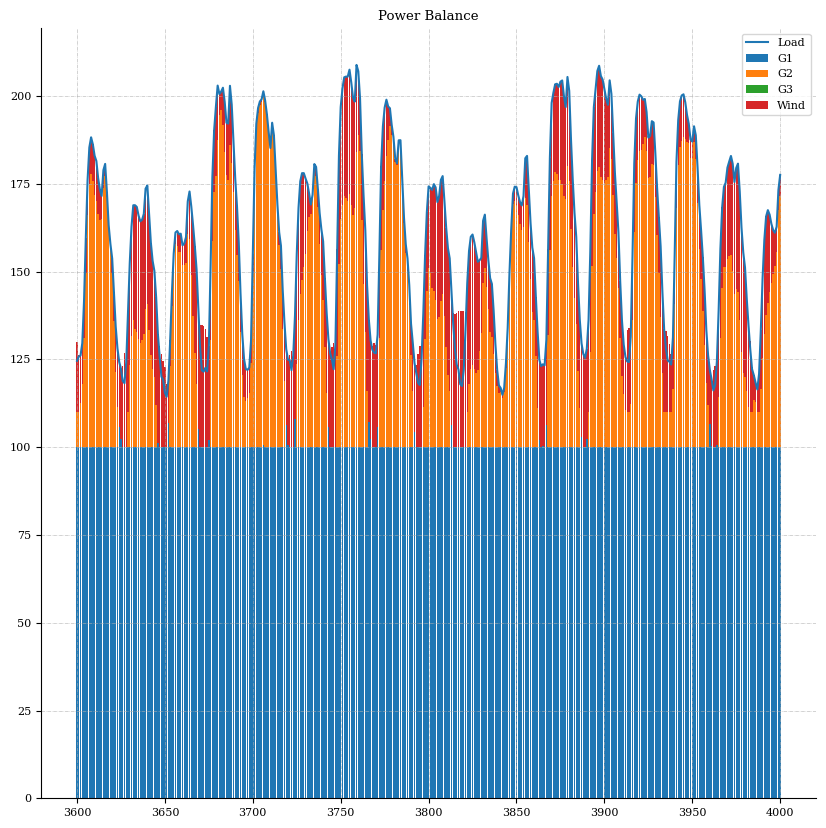

4000 4400


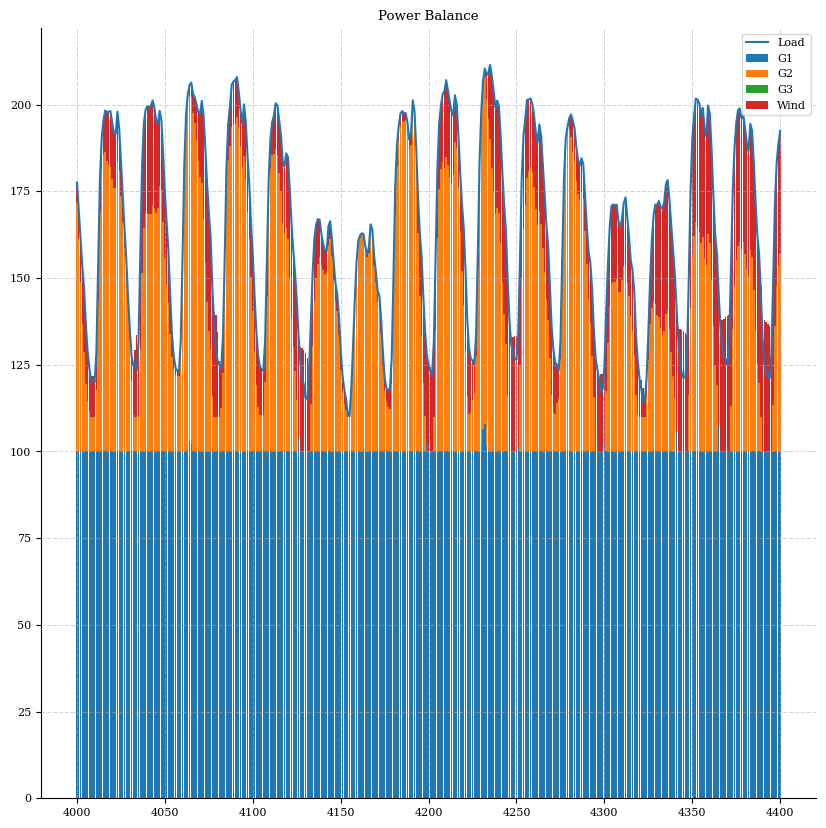

4400 4800


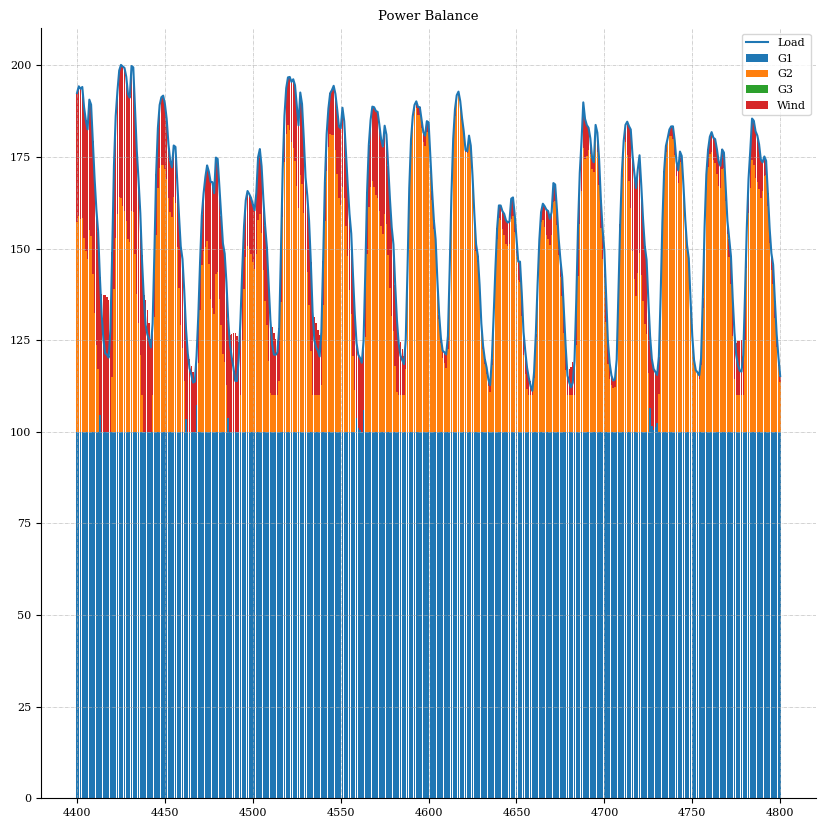

4800 5200


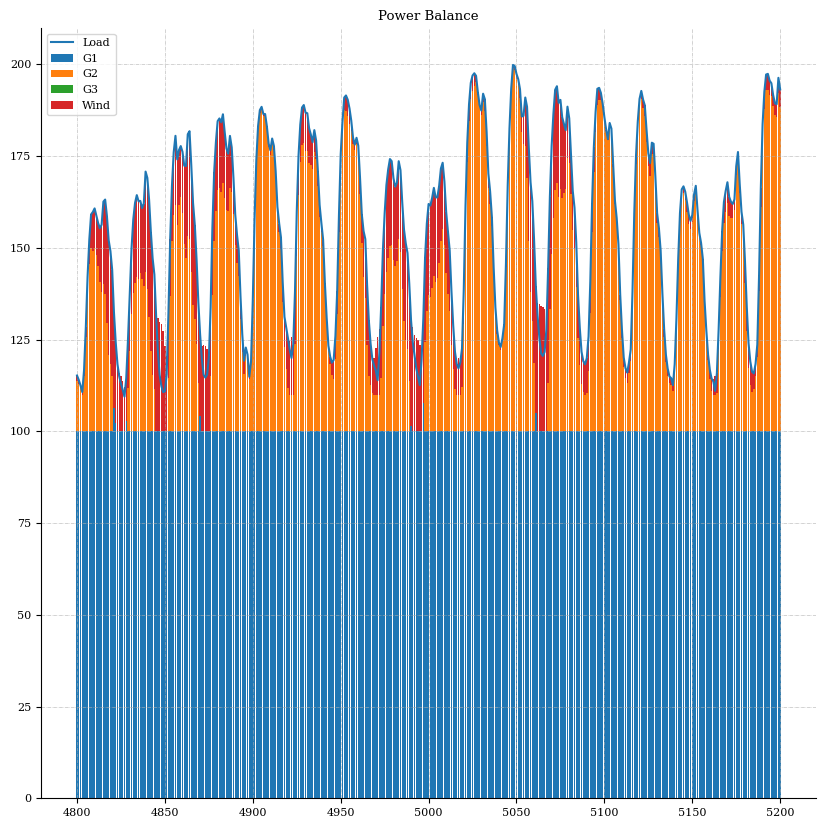

5200 5600


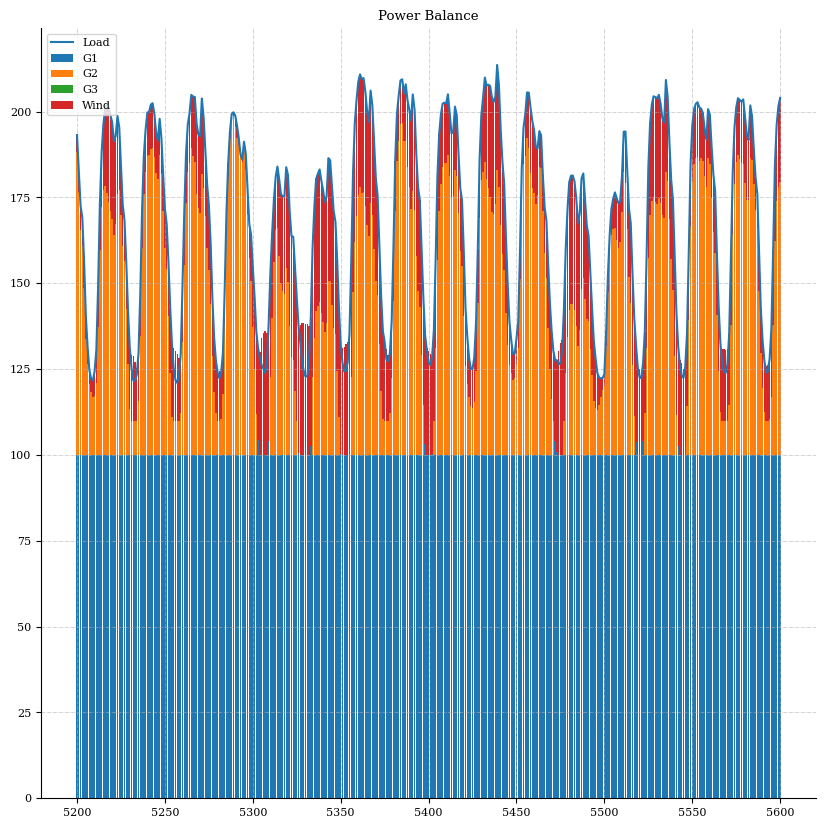

5600 6000


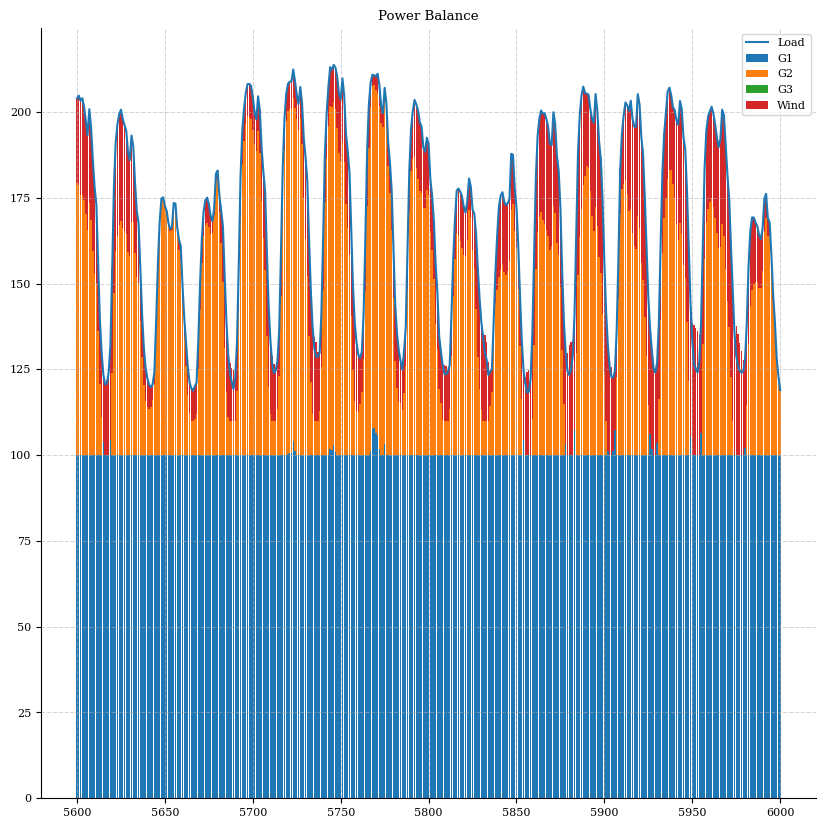

6000 6400


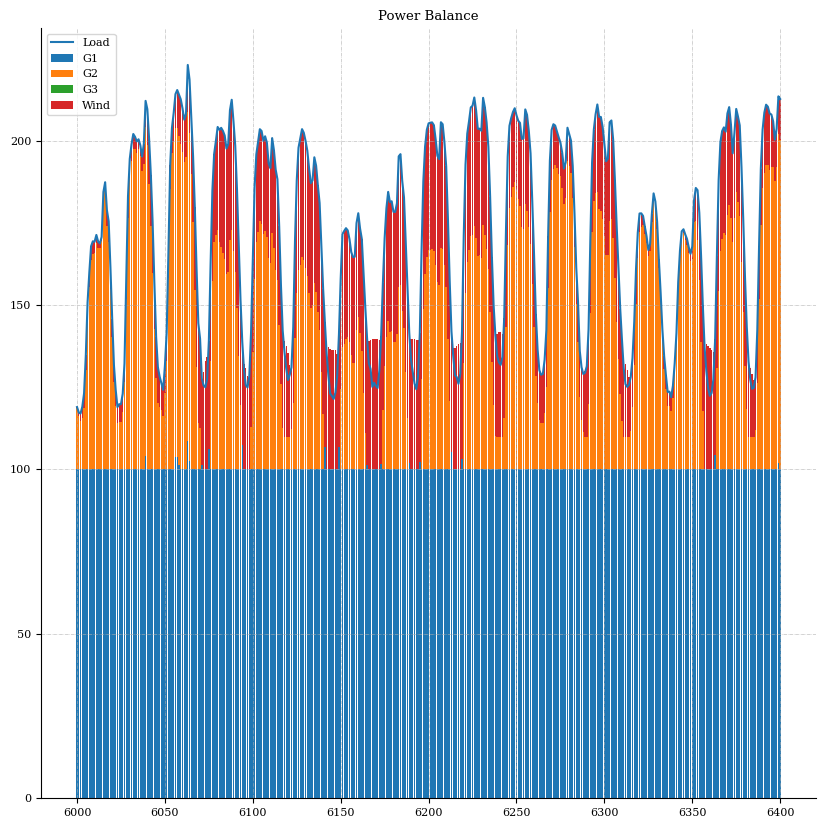

6400 6800


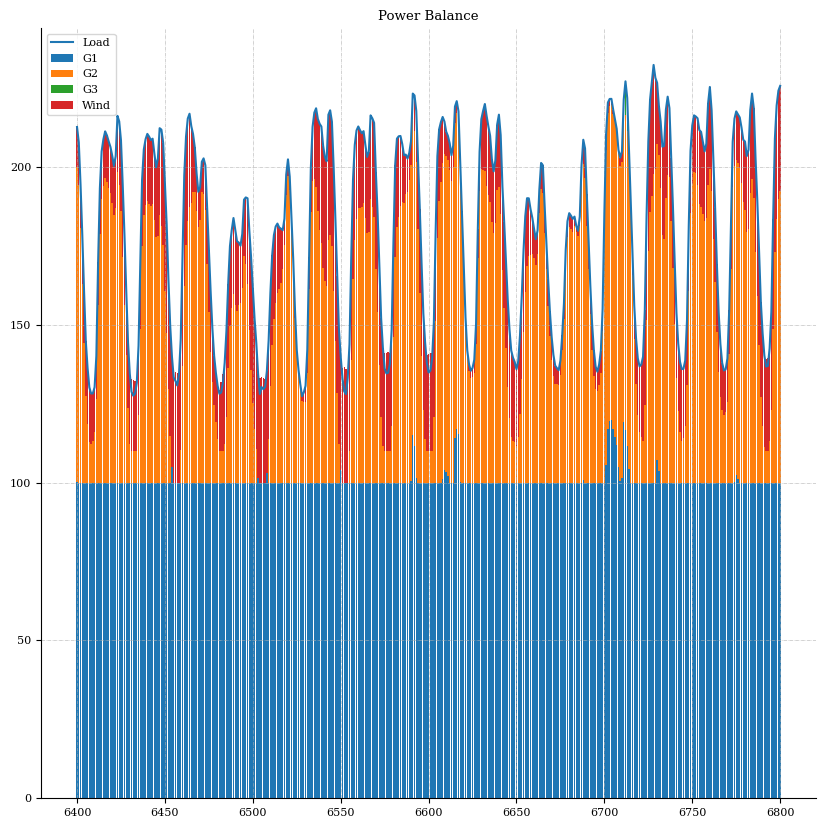

6800 7200


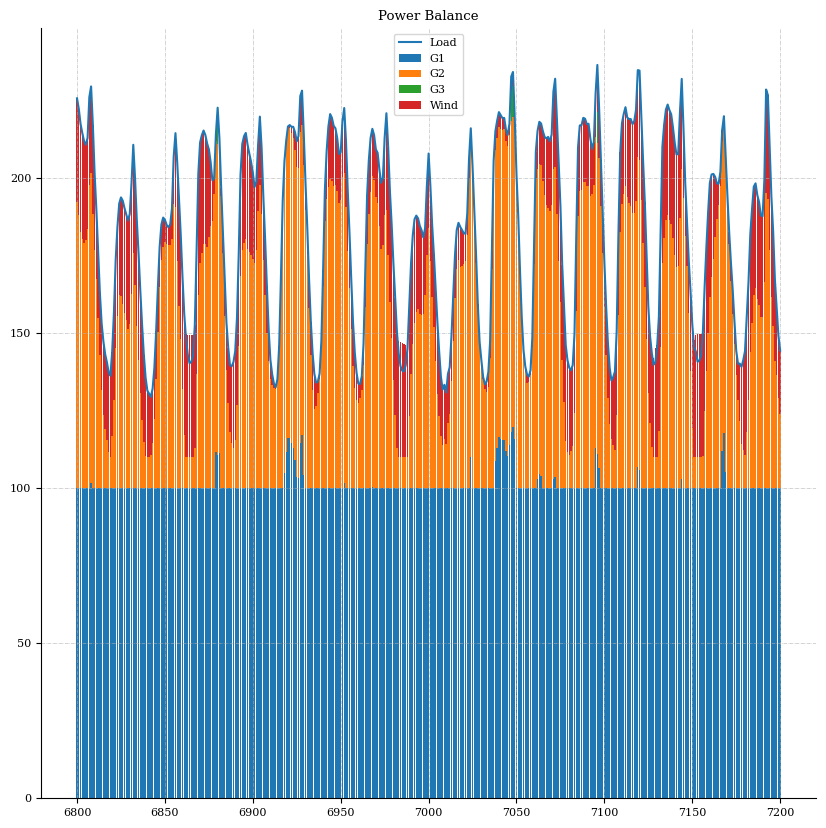

7200 7600


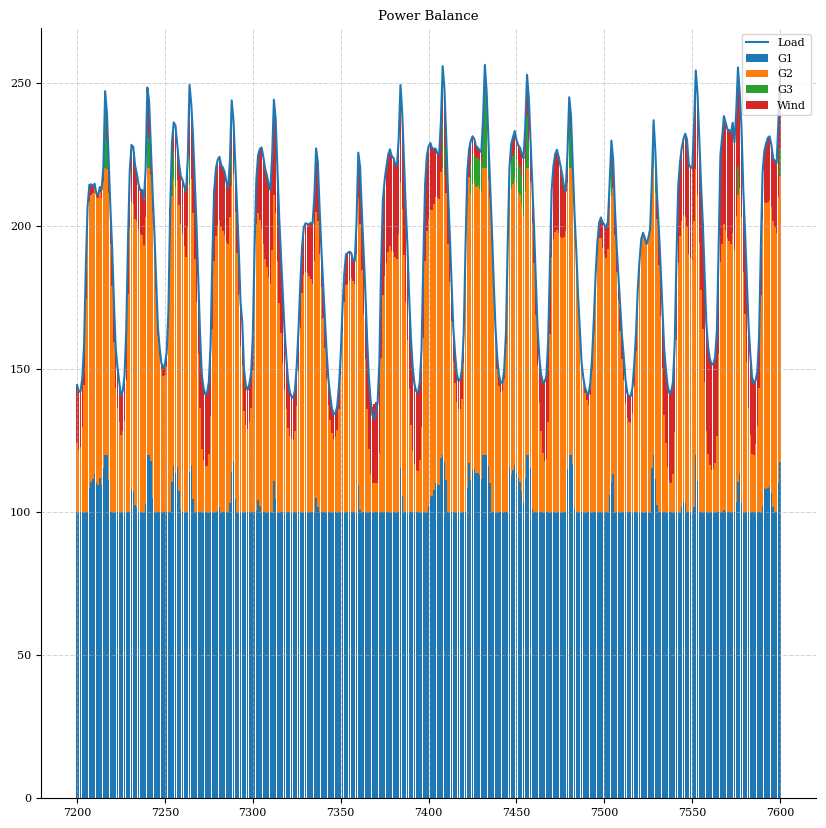

7600 8000


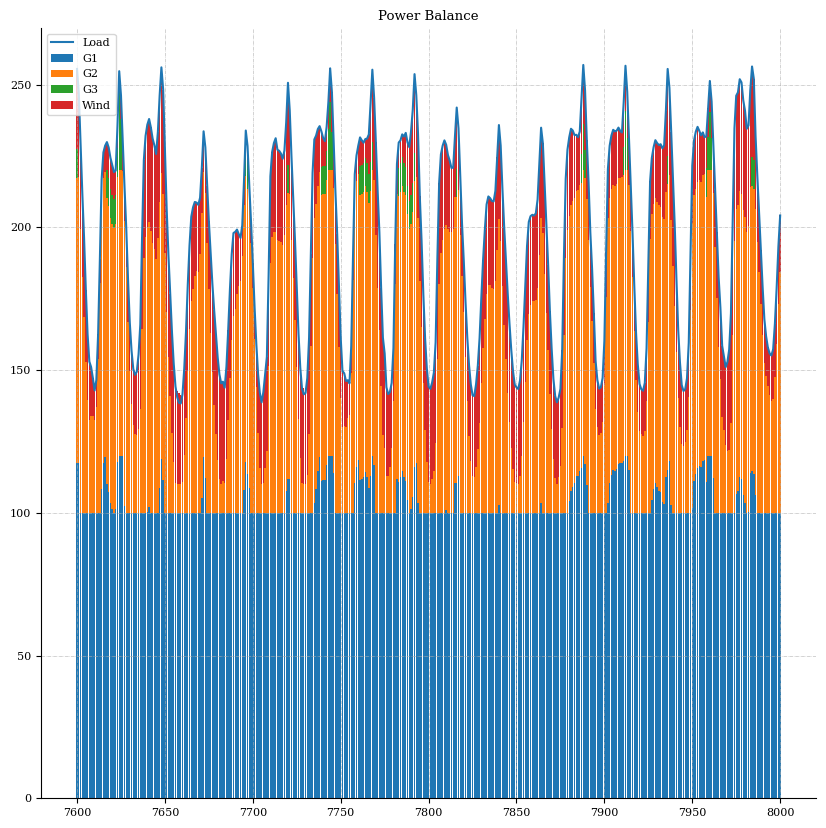

8000 8400


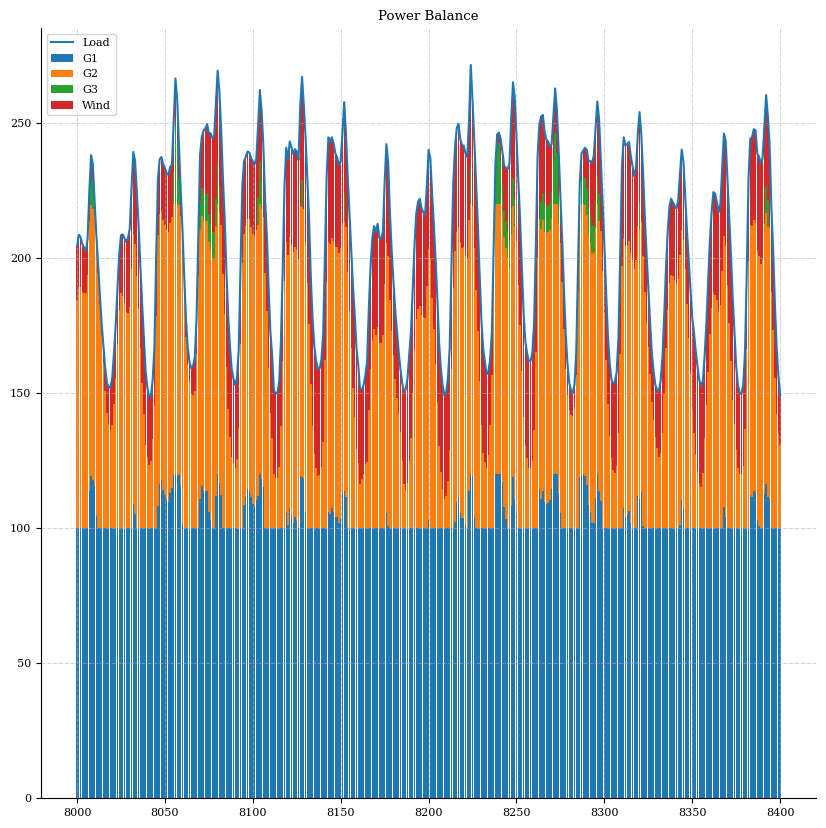

In [40]:
plot = 1
if plot:
    ## Some plots for analysis
    data0 = pd.read_csv('./Inputs/Processed/model_data_all_features_25-11-2024.csv', sep = ',')

    print(data0.head(10).to_string())


    # Plot all absolute dispatch and load
    data0.gen1.plot()
    data0.gen2.plot()
    data0.gen3.plot()
    data0.gen4.plot()
    data0.gen5.plot()
    data0.TotalDemand.plot()
    plt.legend()
    #plt.savefig(f'./figures/25-11/0_all_gen_load_25-11-2024.png')
    plt.show()

    plt.figure(figsize = (10,10))
    d1 = data0.d1
    d2 = data0.d2
    d3 = data0.d3
    d4 = data0.d4
    d5 = data0.d5
    d6 = data0.d6 + 112 + 112 + 56
    d = d1 + d2 + d3 + d4 + d5 + d6
    d.plot(label = 'Slack Variables')
    plt.axhline(y=112 + 112 + 56, label = 'load limit = 280 MW', color = 'r')
    data0.TotalDemand.plot(label = 'Load')
    plt.legend()
    #plt.savefig(f'./figures/25-11/slacks_25-11-2024.png')
    plt.show()
    #

    # Plot Binaries
    plt.figure(figsize=(10, 7))
    data0.u1.plot()
    u2 = data0.u2 + 1.1
    u2.plot()

    u3 = data0.u3 + 2.5
    u3.plot()

    u4 = data0.u4 + 3.1
    u4.plot()

    u5 = data0.u5 + 4.1
    u5.plot()

    plt.legend()
    plt.ylim(0,6)
    #plt.savefig(f'./figures/25-11/u_25-11-2024.png')
    plt.show()
    
    # Plot Startup 
    data0.s1.plot()
    data0.s2.plot()
    data0.s3.plot()
    data0.s4.plot()
    data0.s5.plot()
    plt.legend()
    plt.show()

    # Plot all results in steps 
    print('-'*100)
    k = 0
    for n in range(int(len(data0)/step)):

        print(k, k+step)
        data = data0.loc[k:k+step]

        plt.figure(figsize=(10,10))

        plt.bar(data.index, data.gen1, label = 'G1')
        plt.bar(data.index, data.gen2, bottom = data.gen1, label = 'G2')
        plt.bar(data.index, data.gen3, bottom = data.gen1+data.gen2, label = 'G3')
        plt.bar(data.index, (data.W1+data.W2), bottom = data.gen1+data.gen2 + data.gen3, label = 'Wind')

        data.TotalDemand.plot(label ='Load')

        g1 = data.gen1
        g12 = g1 + data.gen2
        g123 = g12 + data.gen3

        plt.legend()
        plt.title('Power Balance')
        #
        #plt.savefig(f'./figures/25-11/optimization_25-11-2024_{n}.png')

        k = k + step

        plt.show()
        #sys.exit()
